In [155]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)
import gc 
gc.collect()

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

799

In [156]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    return  score/2
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.00000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols

In [157]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.shape
#train = train[[x for x in train.index if x not in vaild.index]].copy()
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col, rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

# 删除异常值
train = train[train['收率'] > 0.87]
train = train[good_cols]
good_cols.remove('收率')
test = test[good_cols]
# 合并数据集
target = train['收率']
train['收率'] = target
data_2 = pd.concat([train,test],axis=0,ignore_index=True)
data_2 = data_2.fillna(-1)
train.shape
std = np.std(target)
mean = np.mean(target)
mean = 0.01
num = 15
column_mean_std = []
time_columns = ['A5', 'A7', 'A9', 'A11', 'A14', 'A16', 'A24', 'A26', 'B5', 'B7','A20', 'A28', 'B4', 'B9', 'B10', 'B11']
time_column = 'B10'
for time_column in time_columns:
    aa = train.groupby(by = time_column)['收率'].agg({time_column+'_count':'count',time_column+'_mean':'mean',time_column+"_std":'std'}).reset_index()
    aa = aa.fillna(100)
    aa.loc[(aa[time_column+'_std']>std) | (aa[time_column+'_count']<num),time_column+'_mean'] = mean
    aa = aa[[time_column,time_column+'_mean',time_column+"_std"]]
    column_mean_std.append(time_column+'_mean')
    column_mean_std.append(time_column+'_std')
    train = train.merge(aa,on = time_column,how = 'left')
    test = test.merge(aa,on = time_column,how = 'left')
len(column_mean_std)
data_2 = pd.concat([train[column_mean_std],test[column_mean_std]],axis=0,ignore_index=True)
data_2 = data_2.fillna(mean)

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [158]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.shape
#train = train[[x for x in train.index if x not in vaild.index]].copy()

(1396, 44)

In [159]:
#特征筛选

In [160]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [161]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


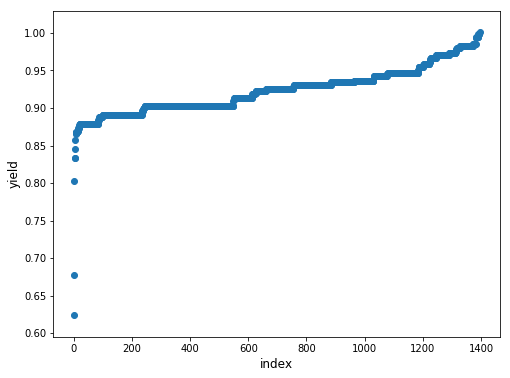

In [162]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

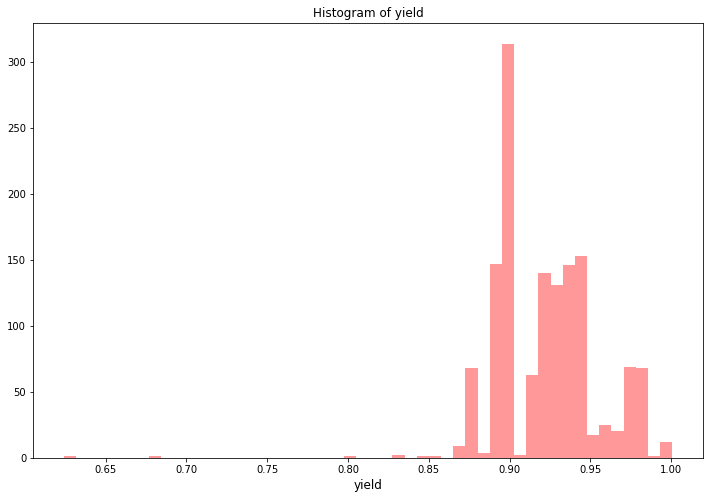

In [163]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [164]:
#train['样本id'] = train['样本id'].map(lambda x:x.split('_')[1])
#plt.figure(figsize=(8,6))
#plt.scatter(train['样本id'], train[target_col])
#plt.xlabel('index', fontsize=12)
#plt.ylabel('yield', fontsize=12)
#plt.show()

In [165]:
"""
tmp = train[train[target_col]>0.92]
tmp['样本id']
plt.figure(figsize=(8,16))
plt.scatter(tmp['样本id'], tmp[target_col])
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()
train.to_csv('chakan.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaa902.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaadayu902.csv',encoding='gbk')
num = 560
print(train.loc[865,target_col])

train['target_feature'] = mean_num
train['target_feature']
for num in range(500,600):
    pre_d_all = []
    for id in train[train[target_col]>0.92]['样本id'].values:
        sum_all = 0
        num_j = 0
        for i in [-3,-2,-1,1,2,3]:
            if (id + i * num) in train['样本id'].values:
                num_j+=1
                sum_all +=train.loc[train['样本id'] == id + i * num,target_col].values
        if num_j == 0:
            pre_d = mean_num
        else:
            pre_d = (sum_all/num_j)[0]
        pre_d_all.append([id,pre_d])
    pre_d_all = pd.DataFrame(pre_d_all)
    pre_d_all.columns =['id','pred']
    pre_d_all = pre_d_all.merge(train[['样本id',target_col]],left_on= 'id',right_on = '样本id',how='left')
    pre_d_all['mean'] = np.mean(pre_d_all[target_col])
    pre_d_all

    print('============================',num)
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))
    pre_d_all
train[train[target_col]>0.92]['样本id']
pre_d_all = pd.DataFrame(pre_d_all)
pre_d_all[target_col] = train[target_col]
pre_d_all['mean'] = np.mean(pre_d_all[target_col])
pre_d_all
pre_d_all.columns =['id','pred' , '收率', 'mean']
print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))"""

"\ntmp = train[train[target_col]>0.92]\ntmp['样本id']\nplt.figure(figsize=(8,16))\nplt.scatter(tmp['样本id'], tmp[target_col])\nplt.xlabel('index', fontsize=12)\nplt.ylabel('yield', fontsize=12)\nplt.show()\ntrain.to_csv('chakan.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaa902.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaadayu902.csv',encoding='gbk')\nnum = 560\nprint(train.loc[865,target_col])\n\ntrain['target_feature'] = mean_num\ntrain['target_feature']\nfor num in range(500,600):\n    pre_d_all = []\n    for id in train[train[target_col]>0.92]['样本id'].values:\n        sum_all = 0\n        num_j = 0\n        for i in [-3,-2,-1,1,2,3]:\

In [166]:
# 删除类别唯一的特征
target_col = "收率"

for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [167]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [168]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [169]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [170]:
data.columns

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'A1', 'A3', 'A4'],
      dtype='object')

In [171]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [172]:
mean_num = np.mean(target)
mean_num
pred_all = []
tmp = pd.DataFrame()
tmp['样本id'] = train['样本id']
tmp['样本id'] = tmp['样本id'].map(lambda x:x.split('_')[1])
tmp['样本id'] = tmp['样本id'].astype(float)
tmp['target'] = target
tmp.reset_index(drop=True,inplace=True)
len(tmp[tmp['样本id']>2000])

0

In [173]:
#num = 20
#for i in range(1,2001):
#    tmp_data = tmp[(tmp['样本id']>= i-num) & (tmp['样本id']<= i+num) & (tmp['样本id'] != i)]
#    if len(tmp_data) != 0:
#        pred = np.mean(tmp_data['target'])
#        std = np.std(tmp_data['target'])
#        pred_all.append([i,pred,std])
#    else:
#        pred_all.append([i,mean_num,-1])

In [174]:
#data = data.merge(pred_all,on = '样本id',how = 'left')
#numerical_columns.append('pred')
#numerical_columns.append('std')
data.shape
data.columns
data.index

RangeIndex(start=0, stop=1531, step=1)

In [175]:
###温度特征data
data['wendu_mean'] = np.mean(data[['A6','A10','A12','A15','A17','A21','A25','A27','B6','B8']],axis=1)
numerical_columns.append('wendu_mean')

In [176]:
# 有风的冬老哥，在群里无意爆出来的特征，让我提升了三个个点，当然也可以顺此继续扩展
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')

del data['A1']
del data['A3']
del data['A4']
categorical_columns.remove('A1')
categorical_columns.remove('A3')
categorical_columns.remove('A4')

In [177]:
data['A25'][data['样本id'] == 1590] = data['A25'][data['样本id'] != 1590].value_counts().values[0]
data['A25'] = data['A25'].astype(float)

In [178]:
data = pd.concat([data,data_2],axis=1)

In [179]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

In [198]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_column_cross = []

In [199]:
train.columns

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'wendu_mean', 'b14/a1_a3_a4_a19_b1_b12', 'A5_mean', 'A5_std',
       'A7_mean', 'A7_std', 'A9_mean', 'A9_std', 'A11_mean', 'A11_std',
       'A14_mean', 'A14_std', 'A16_mean', 'A16_std', 'A24_mean', 'A24_std',
       'A26_mean', 'A26_std', 'B5_mean', 'B5_std', 'B7_mean', 'B7_std',
       'A20_mean', 'A20_std', 'A28_mean', 'A28_std', 'B4_mean', 'B4_std',
       'B9_mean', 'B9_std', 'B10_mean', 'B10_std', 'B11_mean', 'B11_std',
       'target', 'intTarget_0.0', 'intTarget_1.0', 'intTarget_2.0',
       'intTarget_3.0', 'intTarget_4.0'],
      dtype='object')

In [202]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_column_cross = []
for f1 in categorical_columns:
    if f1 == 'B14':
        break
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    print(categorical_columns)
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_'+f1+"_"+f2+'_mean'
            mean_column_cross.append(col_name)
            order_label = train.groupby([f1,'B14'])[f2].agg({'B14_'+f1+"_"+f2+'_mean':'mean'}).reset_index()
            train = train.merge(order_label,on = [f1,'B14',],how = 'left')
            test = test.merge(order_label,on = [f1,'B14'],how = 'left')
            miss_rate = test[col_name].isnull().sum()  / test[col_name].shape[0]
            print(miss_rate)
            if miss_rate  > 0.5:
                train = train.drop([col_name], axis=1)
                test = test.drop([col_name], axis=1)
                mean_column_cross.remove(col_name)
                print('shanchu============',col_name)
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.04666666666666667
0.04666666666666667
0.04666666666666667
0.04666666666666667
0.04666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']


0.06
0.06
0.06
0.06
0.06
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.006666666666666667
0.006666666666666667


0.006666666666666667
0.006666666666666667
0.006666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334


0.013333333333333334
0.013333333333333334
0.013333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.06666666666666667
0.06666666666666667


0.06666666666666667
0.06666666666666667
0.06666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02
0.02
0.02


0.02
0.02
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02
0.02


0.02
0.02
0.02
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


0.013333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.006666666666666667
0.006666666666666667
0.006666666666666667
0.006666666666666667
0.006666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.06


0.06
0.06
0.06
0.06


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02
0.02
0.02
0.02


0.02
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333
0.07333333333333333


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


0.013333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.006666666666666667
0.006666666666666667
0.006666666666666667
0.006666666666666667


0.006666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02
0.02
0.02
0.02


0.02
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667


['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02666666666666667
0.02666666666666667
0.02666666666666667
0.02666666666666667


0.02666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.05333333333333334
0.05333333333333334
0.05333333333333334
0.05333333333333334


0.05333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


0.013333333333333334
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02666666666666667
0.02666666666666667
0.02666666666666667
0.02666666666666667


0.02666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.02
0.02
0.02
0.02


0.02
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.006666666666666667
0.006666666666666667
0.006666666666666667
0.006666666666666667


0.006666666666666667
['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27', 'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B14']
0.013333333333333334
0.013333333333333334
0.013333333333333334
0.013333333333333334


0.013333333333333334
(1381, 222)
(150, 222)


In [203]:
train.columns

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14',
       ...
       'B14_B11_intTarget_0.0_mean', 'B14_B11_intTarget_1.0_mean',
       'B14_B11_intTarget_2.0_mean', 'B14_B11_intTarget_3.0_mean',
       'B14_B11_intTarget_4.0_mean', 'B14_B12_intTarget_0.0_mean',
       'B14_B12_intTarget_1.0_mean', 'B14_B12_intTarget_2.0_mean',
       'B14_B12_intTarget_3.0_mean', 'B14_B12_intTarget_4.0_mean'],
      dtype='object', length=222)

In [207]:
mean_column_cross

['B14_A5_intTarget_0.0_mean',
 'B14_A5_intTarget_1.0_mean',
 'B14_A5_intTarget_2.0_mean',
 'B14_A5_intTarget_3.0_mean',
 'B14_A5_intTarget_4.0_mean',
 'B14_A6_intTarget_0.0_mean',
 'B14_A6_intTarget_1.0_mean',
 'B14_A6_intTarget_2.0_mean',
 'B14_A6_intTarget_3.0_mean',
 'B14_A6_intTarget_4.0_mean',
 'B14_A7_intTarget_0.0_mean',
 'B14_A7_intTarget_1.0_mean',
 'B14_A7_intTarget_2.0_mean',
 'B14_A7_intTarget_3.0_mean',
 'B14_A7_intTarget_4.0_mean',
 'B14_A8_intTarget_0.0_mean',
 'B14_A8_intTarget_1.0_mean',
 'B14_A8_intTarget_2.0_mean',
 'B14_A8_intTarget_3.0_mean',
 'B14_A8_intTarget_4.0_mean',
 'B14_A9_intTarget_0.0_mean',
 'B14_A9_intTarget_1.0_mean',
 'B14_A9_intTarget_2.0_mean',
 'B14_A9_intTarget_3.0_mean',
 'B14_A9_intTarget_4.0_mean',
 'B14_A10_intTarget_0.0_mean',
 'B14_A10_intTarget_1.0_mean',
 'B14_A10_intTarget_2.0_mean',
 'B14_A10_intTarget_3.0_mean',
 'B14_A10_intTarget_4.0_mean',
 'B14_A11_intTarget_0.0_mean',
 'B14_A11_intTarget_1.0_mean',
 'B14_A11_intTarget_2.0_mean',
 '

In [206]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 297)
(150, 297)


In [131]:
##mean_columns = []
##for f1 in categorical_columns:
##    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
##    if cate_rate < 0.90:
##        for f2 in li:
##            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
##            mean_columns.append(col_name)
##            order_label = train.groupby([f1])[f2].mean()
##            train[col_name] = train['B14'].map(order_label)
##            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
##            if miss_rate > 0:
##                train = train.drop([col_name], axis=1)
##                mean_columns.remove(col_name)
##            else:
##                test[col_name] = test['B14'].map(order_label)
##                
##train.drop(li+['target'], axis=1, inplace=True)
##print(train.shape)
##print(test.shape)

In [132]:
#是否进行特征筛选
train_columns_list = mean_columns+numerical_columns
best_features = featureSelect(train_columns_list)
mean_columns = [x for x in mean_columns if x in best_features]
print(len(mean_columns))
numerical_columns = [x for x in numerical_columns if x in best_features]
print(len(numerical_columns))
print(numerical_columns)

fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[296]	training's l2: 7.29449e-05	valid_1's l2: 0.000142971
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[590]	training's l2: 5.84022e-05	valid_1's l2: 0.000140167
fold n°3
Training until validation scores don't improve for 100 rounds.

KeyboardInterrupt: 

In [223]:
#X_train = train[mean_columns+numerical_columns].values
#X_test = test[mean_columns+numerical_columns].values+column_mean_std +column_mean_std
X_train = train[numerical_columns +mean_columns + mean_column_cross].values
X_test = test[numerical_columns +mean_columns+ mean_column_cross].values

In [224]:
train.shape

(1381, 297)

In [225]:
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_test.shape)
print(X_train.shape)

(150, 1395)
(1381, 1395)


In [234]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
y_train = target.values
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))

fold n°1
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000172398	valid_1's l2: 0.000192847


[400]	training's l2: 0.000113595	valid_1's l2: 0.000143294


[600]	training's l2: 9.01588e-05	valid_1's l2: 0.000126951


[800]	training's l2: 7.94373e-05	valid_1's l2: 0.000121297


[1000]	training's l2: 7.25727e-05	valid_1's l2: 0.000118376


[1200]	training's l2: 6.78481e-05	valid_1's l2: 0.000116255


[1400]	training's l2: 6.4348e-05	valid_1's l2: 0.000114743


[1600]	training's l2: 6.1557e-05	valid_1's l2: 0.000113509


[1800]	training's l2: 5.92918e-05	valid_1's l2: 0.00011264


[2000]	training's l2: 5.74161e-05	valid_1's l2: 0.00011214


[2200]	training's l2: 5.58194e-05	valid_1's l2: 0.000111562


[2400]	training's l2: 5.44379e-05	valid_1's l2: 0.000111286
[2600]	training's l2: 5.34546e-05	valid_1's l2: 0.000110894


Early stopping, best iteration is:
[2557]	training's l2: 5.34546e-05	valid_1's l2: 0.000110894


fold n°2
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.00016636	valid_1's l2: 0.000202841


[400]	training's l2: 0.000105124	valid_1's l2: 0.00016668


[600]	training's l2: 8.25755e-05	valid_1's l2: 0.000157074


[800]	training's l2: 7.20753e-05	valid_1's l2: 0.000155147


[1000]	training's l2: 6.52363e-05	valid_1's l2: 0.00015381


[1200]	training's l2: 6.03481e-05	valid_1's l2: 0.000152958


[1400]	training's l2: 5.67706e-05	valid_1's l2: 0.000152488


[1600]	training's l2: 5.40837e-05	valid_1's l2: 0.000152315
Early stopping, best iteration is:
[1533]	training's l2: 5.48825e-05	valid_1's l2: 0.000152228


fold n°3
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000165434	valid_1's l2: 0.000199149


[400]	training's l2: 0.000106724	valid_1's l2: 0.000159121


[600]	training's l2: 8.40747e-05	valid_1's l2: 0.000145582


[800]	training's l2: 7.40068e-05	valid_1's l2: 0.00014153


[1000]	training's l2: 6.7592e-05	valid_1's l2: 0.000139097


[1200]	training's l2: 6.31931e-05	valid_1's l2: 0.000137749


[1400]	training's l2: 5.9708e-05	valid_1's l2: 0.000136799


[1600]	training's l2: 5.71379e-05	valid_1's l2: 0.000136211


[1800]	training's l2: 5.50785e-05	valid_1's l2: 0.000135815


[2000]	training's l2: 5.33339e-05	valid_1's l2: 0.000135521


[2200]	training's l2: 5.18084e-05	valid_1's l2: 0.000135178
Early stopping, best iteration is:
[2251]	training's l2: 5.14617e-05	valid_1's l2: 0.000135053


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000169167	valid_1's l2: 0.000198752


[400]	training's l2: 0.000110865	valid_1's l2: 0.000158841


[600]	training's l2: 8.6712e-05	valid_1's l2: 0.000143874


[800]	training's l2: 7.52413e-05	valid_1's l2: 0.000137619


[1000]	training's l2: 6.81688e-05	valid_1's l2: 0.000134793


[1200]	training's l2: 6.31867e-05	valid_1's l2: 0.000133023


[1400]	training's l2: 5.93677e-05	valid_1's l2: 0.000132073


[1600]	training's l2: 5.64496e-05	valid_1's l2: 0.000131307


[1800]	training's l2: 5.42238e-05	valid_1's l2: 0.000130816


[2000]	training's l2: 5.24294e-05	valid_1's l2: 0.000130643


[2200]	training's l2: 5.08828e-05	valid_1's l2: 0.000130425


[2400]	training's l2: 4.95117e-05	valid_1's l2: 0.000130158
Early stopping, best iteration is:
[2385]	training's l2: 4.96044e-05	valid_1's l2: 0.000130121


fold n°5
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000174392	valid_1's l2: 0.000177883


[400]	training's l2: 0.00011555	valid_1's l2: 0.000120543


[600]	training's l2: 9.01011e-05	valid_1's l2: 0.000103412


[800]	training's l2: 7.85161e-05	valid_1's l2: 0.000100102


[1000]	training's l2: 7.12435e-05	valid_1's l2: 9.8923e-05


[1200]	training's l2: 6.6535e-05	valid_1's l2: 9.84596e-05


[1400]	training's l2: 6.27281e-05	valid_1's l2: 9.82748e-05


[1600]	training's l2: 5.97576e-05	valid_1's l2: 9.79511e-05


Early stopping, best iteration is:
[1671]	training's l2: 5.88681e-05	valid_1's l2: 9.78891e-05


CV score: 0.00012523


In [228]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4,}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256988	valid_data-rmse:0.257757


[200]	train-rmse:0.156508	valid_data-rmse:0.157407


[300]	train-rmse:0.095711	valid_data-rmse:0.096547


[400]	train-rmse:0.059111	valid_data-rmse:0.059933


[500]	train-rmse:0.037143	valid_data-rmse:0.038138


[600]	train-rmse:0.023935	valid_data-rmse:0.025369


[700]	train-rmse:0.016042	valid_data-rmse:0.018181


[800]	train-rmse:0.01132	valid_data-rmse:0.014395


[900]	train-rmse:0.008549	valid_data-rmse:0.012518


[1000]	train-rmse:0.006923	valid_data-rmse:0.011652


[1100]	train-rmse:0.005932	valid_data-rmse:0.011245


[1200]	train-rmse:0.005286	valid_data-rmse:0.011058


[1300]	train-rmse:0.004828	valid_data-rmse:0.010969


[1400]	train-rmse:0.004467	valid_data-rmse:0.010925


[1500]	train-rmse:0.004134	valid_data-rmse:0.010886


[1600]	train-rmse:0.003848	valid_data-rmse:0.010873


[1700]	train-rmse:0.003559	valid_data-rmse:0.010866


[1800]	train-rmse:0.003296	valid_data-rmse:0.010876


[1900]	train-rmse:0.003038	valid_data-rmse:0.010873


Stopping. Best iteration:
[1702]	train-rmse:0.003555	valid_data-rmse:0.010865



fold n°2


[0]	train-rmse:0.424042	valid_data-rmse:0.419362


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257691	valid_data-rmse:0.254128


[200]	train-rmse:0.156922	valid_data-rmse:0.153992


[300]	train-rmse:0.095938	valid_data-rmse:0.093478


[400]	train-rmse:0.059204	valid_data-rmse:0.057244


[500]	train-rmse:0.037146	valid_data-rmse:0.03596


[600]	train-rmse:0.023863	valid_data-rmse:0.023825


[700]	train-rmse:0.015876	valid_data-rmse:0.017277


[800]	train-rmse:0.011084	valid_data-rmse:0.014026


[900]	train-rmse:0.008228	valid_data-rmse:0.012562


[1000]	train-rmse:0.00653	valid_data-rmse:0.011964


[1100]	train-rmse:0.005506	valid_data-rmse:0.011729


[1200]	train-rmse:0.004875	valid_data-rmse:0.011655


[1300]	train-rmse:0.004411	valid_data-rmse:0.011636


[1400]	train-rmse:0.004073	valid_data-rmse:0.011643


[1500]	train-rmse:0.003767	valid_data-rmse:0.011657


Stopping. Best iteration:
[1326]	train-rmse:0.004307	valid_data-rmse:0.011634



fold n°3


[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256656	valid_data-rmse:0.259775


[200]	train-rmse:0.156289	valid_data-rmse:0.159013


[300]	train-rmse:0.095584	valid_data-rmse:0.097881


[400]	train-rmse:0.059016	valid_data-rmse:0.061023


[500]	train-rmse:0.037073	valid_data-rmse:0.03899


[600]	train-rmse:0.023876	valid_data-rmse:0.025978


[700]	train-rmse:0.015954	valid_data-rmse:0.018689


[800]	train-rmse:0.011232	valid_data-rmse:0.014858


[900]	train-rmse:0.008435	valid_data-rmse:0.013024


[1000]	train-rmse:0.006761	valid_data-rmse:0.012196


[1100]	train-rmse:0.005723	valid_data-rmse:0.011845


[1200]	train-rmse:0.005067	valid_data-rmse:0.011705


[1300]	train-rmse:0.004634	valid_data-rmse:0.011643


[1400]	train-rmse:0.004292	valid_data-rmse:0.011621


[1500]	train-rmse:0.003996	valid_data-rmse:0.011619


[1600]	train-rmse:0.003726	valid_data-rmse:0.011628


Stopping. Best iteration:
[1466]	train-rmse:0.004095	valid_data-rmse:0.011617



fold n°4

[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257	valid_data-rmse:0.256924


[200]	train-rmse:0.156478	valid_data-rmse:0.156244


[300]	train-rmse:0.095695	valid_data-rmse:0.095517


[400]	train-rmse:0.059075	valid_data-rmse:0.058954


[500]	train-rmse:0.037096	valid_data-rmse:0.037285


[600]	train-rmse:0.023876	valid_data-rmse:0.024699


[700]	train-rmse:0.015944	valid_data-rmse:0.017811


[800]	train-rmse:0.01117	valid_data-rmse:0.014308


[900]	train-rmse:0.008339	valid_data-rmse:0.012669


[1000]	train-rmse:0.006652	valid_data-rmse:0.011962


[1100]	train-rmse:0.005656	valid_data-rmse:0.011675


[1200]	train-rmse:0.005009	valid_data-rmse:0.011558


[1300]	train-rmse:0.004536	valid_data-rmse:0.011513


[1400]	train-rmse:0.004152	valid_data-rmse:0.011497


[1500]	train-rmse:0.003845	valid_data-rmse:0.011494


[1600]	train-rmse:0.003532	valid_data-rmse:0.011499


Stopping. Best iteration:
[1475]	train-rmse:0.003902	valid_data-rmse:0.011492



fold n°5


[0]	train-rmse:0.423228	valid_data-rmse:0.422635


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257149	valid_data-rmse:0.256825


[200]	train-rmse:0.156582	valid_data-rmse:0.156303


[300]	train-rmse:0.095762	valid_data-rmse:0.095538


[400]	train-rmse:0.059137	valid_data-rmse:0.059132


[500]	train-rmse:0.037172	valid_data-rmse:0.037535


[600]	train-rmse:0.023966	valid_data-rmse:0.024847


[700]	train-rmse:0.016066	valid_data-rmse:0.017635


[800]	train-rmse:0.011359	valid_data-rmse:0.013826


[900]	train-rmse:0.008569	valid_data-rmse:0.011909


[1000]	train-rmse:0.006914	valid_data-rmse:0.01102


[1100]	train-rmse:0.005914	valid_data-rmse:0.010611


[1200]	train-rmse:0.005267	valid_data-rmse:0.010434


[1300]	train-rmse:0.004806	valid_data-rmse:0.010364


[1400]	train-rmse:0.004492	valid_data-rmse:0.010339


[1500]	train-rmse:0.004185	valid_data-rmse:0.010323


[1600]	train-rmse:0.003912	valid_data-rmse:0.010338


Stopping. Best iteration:
[1469]	train-rmse:0.004276	valid_data-rmse:0.010321



CV score: 0.00012539


In [235]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print(mean_squared_error(y_train, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
0.00012143562790058093


In [215]:
sub_df = pd.read_csv('./jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))

In [300]:
sub_df.to_csv('solution.csv',index=False,header=False,encoding='gbk')

In [216]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [217]:
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.00000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
train_columns_list = numerical_columns +column_mean_std+mean_columns + mean_column_cross
best_features = featureSelect(train_columns_list)

fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[145]	training's l2: 4.8731e-05	valid_1's l2: 0.000139679
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[261]	training's l2: 3.18783e-05	valid_1's l2: 0.000146147
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.25328e-05	valid_1's l2: 0.000108349
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.59626e-05	valid_1's l2: 0.000108142
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[150]	training's l2: 4.79744e-05	valid_1's l2: 0.000151928
初始CV score: 0.00006543
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[94]	training's l2: 0.000104955	valid_1's l2: 0.000187568
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[70]	training's l2: 0.000116033	valid_1's l2: 0.000213429
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 8.99778e-05	valid_1's l2: 0.000150948
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 9.78968e-05	valid_1's l2: 0.000143683
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[95]	training's l2: 0.000103692	valid_1's l2: 0.000193651
----------
当前移除特征: 样本id, CV score: 0.00008893, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.81598e-05	valid_1's l2: 0.000138943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.40958e-05	valid_1's l2: 0.00014715
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 4.07106e-05	valid_1's l2: 0.000109614
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 2.9912e-05	valid_1's l2: 0.000108578
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.76177e-05	valid_1's l2: 0.00015233
----------
当前移除特征: wendu_mean, CV score: 0.00006566, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.02991e-05	valid_1's l2: 0.000138313
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.34321e-05	valid_1's l2: 0.000148376
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.43375e-05	valid_1's l2: 0.000103848
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[255]	training's l2: 3.57801e-05	valid_1's l2: 0.000111655
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 5.22897e-05	valid_1's l2: 0.000154314
----------
当前移除特征: b14/a1_a3_a4_a19_b1_b12, CV score: 0.00006565, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.07526e-05	valid_1's l2: 0.000140741
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.63654e-05	valid_1's l2: 0.000145646
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.01798e-05	valid_1's l2: 0.000106142
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[384]	training's l2: 2.68059e-05	valid_1's l2: 0.00010982
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.3208e-05	valid_1's l2: 0.000153434
----------
当前移除特征: A5_mean, CV score: 0.00006558, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.7803e-05	valid_1's l2: 0.000139807
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[191]	training's l2: 4.01214e-05	valid_1's l2: 0.000147283
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[153]	training's l2: 5.1629e-05	valid_1's l2: 0.000106578
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[259]	training's l2: 3.5232e-05	valid_1's l2: 0.000109717
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.41414e-05	valid_1's l2: 0.000151115
----------
当前移除特征: A5_std, CV score: 0.00006545, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.1208e-05	valid_1's l2: 0.000140911
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 3.09568e-05	valid_1's l2: 0.000144112
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 4.32146e-05	valid_1's l2: 0.000106842
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 3.41257e-05	valid_1's l2: 0.000108406
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.25253e-05	valid_1's l2: 0.000154927
----------
当前移除特征: A7_mean, CV score: 0.00006552, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[153]	training's l2: 4.71195e-05	valid_1's l2: 0.000140503
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 2.83273e-05	valid_1's l2: 0.000149685
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.43442e-05	valid_1's l2: 0.000102935
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.61556e-05	valid_1's l2: 0.000109303
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.56341e-05	valid_1's l2: 0.000153183
----------
当前移除特征: A7_std, CV score: 0.00006556, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.92352e-05	valid_1's l2: 0.000139862
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.05544e-05	valid_1's l2: 0.000149199
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.30665e-05	valid_1's l2: 0.000107141
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[486]	training's l2: 2.30124e-05	valid_1's l2: 0.000107346
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[202]	training's l2: 3.84083e-05	valid_1's l2: 0.000151073
----------
当前移除特征: A9_mean, CV score: 0.00006547, 最佳cv score: 0.00006543, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[106]	training's l2: 6.32993e-05	valid_1's l2: 0.000141778
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.98442e-05	valid_1's l2: 0.000144762
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.34867e-05	valid_1's l2: 0.000105403
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[529]	training's l2: 2.19377e-05	valid_1's l2: 0.000108633
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[98]	training's l2: 6.4313e-05	valid_1's l2: 0.000152417
----------
当前移除特征: A9_std, CV score: 0.00006530, 最佳cv score: 0.00006543, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.93775e-05	valid_1's l2: 0.000141145
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 3.6782e-05	valid_1's l2: 0.000146685
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.38312e-05	valid_1's l2: 0.000105139
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.93658e-05	valid_1's l2: 0.000107781
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.53176e-05	valid_1's l2: 0.000151147
----------
当前移除特征: A11_mean, CV score: 0.00006519, 最佳cv score: 0.00006530, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.89279e-05	valid_1's l2: 0.00014221
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[346]	training's l2: 2.60751e-05	valid_1's l2: 0.000148341
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.31389e-05	valid_1's l2: 0.000107295
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.54916e-05	valid_1's l2: 0.000110801
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.43057e-05	valid_1's l2: 0.000153043
----------
当前移除特征: A11_std, CV score: 0.00006617, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.15085e-05	valid_1's l2: 0.000142191
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[222]	training's l2: 3.55635e-05	valid_1's l2: 0.000146019
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.35811e-05	valid_1's l2: 0.000108085
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.95145e-05	valid_1's l2: 0.000112593
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.18271e-05	valid_1's l2: 0.000154369
----------
当前移除特征: A14_mean, CV score: 0.00006633, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.11974e-05	valid_1's l2: 0.000140519
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 2.87078e-05	valid_1's l2: 0.000148748
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.52822e-05	valid_1's l2: 0.000104482
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[250]	training's l2: 3.65326e-05	valid_1's l2: 0.000110292
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.83249e-05	valid_1's l2: 0.00015136
----------
当前移除特征: A14_std, CV score: 0.00006554, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.58873e-05	valid_1's l2: 0.00013922
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.5202e-05	valid_1's l2: 0.000148875
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.50544e-05	valid_1's l2: 0.000107006
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.38529e-05	valid_1's l2: 0.000109574
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.81816e-05	valid_1's l2: 0.000154056
----------
当前移除特征: A16_mean, CV score: 0.00006588, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.14865e-05	valid_1's l2: 0.000139202
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.19758e-05	valid_1's l2: 0.000145411
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.3255e-05	valid_1's l2: 0.000104226
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[312]	training's l2: 3.11749e-05	valid_1's l2: 0.000110011
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.59065e-05	valid_1's l2: 0.000153604
----------
当前移除特征: A16_std, CV score: 0.00006525, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.99759e-05	valid_1's l2: 0.000136618
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.23344e-05	valid_1's l2: 0.00014716
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.40276e-05	valid_1's l2: 0.000109098
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[355]	training's l2: 2.82706e-05	valid_1's l2: 0.000111588
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.71741e-05	valid_1's l2: 0.000154726
----------
当前移除特征: A24_mean, CV score: 0.00006592, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 5.55459e-05	valid_1's l2: 0.000145037
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[347]	training's l2: 2.59364e-05	valid_1's l2: 0.000146391
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.01751e-05	valid_1's l2: 0.000109817
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 2.93196e-05	valid_1's l2: 0.000107751
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.52718e-05	valid_1's l2: 0.000154508
----------
当前移除特征: A24_std, CV score: 0.00006635, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.15458e-05	valid_1's l2: 0.00014139
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[424]	training's l2: 2.27553e-05	valid_1's l2: 0.000146516
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.37824e-05	valid_1's l2: 0.000107403
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[289]	training's l2: 3.25185e-05	valid_1's l2: 0.000110799
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.26822e-05	valid_1's l2: 0.00015118
----------
当前移除特征: A26_mean, CV score: 0.00006573, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[123]	training's l2: 5.60263e-05	valid_1's l2: 0.000141442
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[222]	training's l2: 3.63191e-05	valid_1's l2: 0.000148562
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.56064e-05	valid_1's l2: 0.000106177
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.5189e-05	valid_1's l2: 0.00010904
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[112]	training's l2: 5.95686e-05	valid_1's l2: 0.000155385
----------
当前移除特征: A26_std, CV score: 0.00006606, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.98926e-05	valid_1's l2: 0.00013993
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[383]	training's l2: 2.42801e-05	valid_1's l2: 0.000149183
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 4.05806e-05	valid_1's l2: 0.000104275
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.5207e-05	valid_1's l2: 0.000108435
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.7633e-05	valid_1's l2: 0.000151469
----------
当前移除特征: B5_mean, CV score: 0.00006533, 最佳cv score: 0.00006519, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.60175e-05	valid_1's l2: 0.000139415
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.50432e-05	valid_1's l2: 0.000143523
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.97681e-05	valid_1's l2: 0.00010498
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 3.92334e-05	valid_1's l2: 0.000107146
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[146]	training's l2: 4.86885e-05	valid_1's l2: 0.000151922
----------
当前移除特征: B5_std, CV score: 0.00006470, 最佳cv score: 0.00006519, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.82425e-05	valid_1's l2: 0.000140044
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.39938e-05	valid_1's l2: 0.000144181
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.34892e-05	valid_1's l2: 0.000104377
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[354]	training's l2: 2.82634e-05	valid_1's l2: 0.000110647
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 5.15943e-05	valid_1's l2: 0.000157586
----------
当前移除特征: B7_mean, CV score: 0.00006569, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.66718e-05	valid_1's l2: 0.000139899
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.86743e-05	valid_1's l2: 0.000148152
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.72387e-05	valid_1's l2: 0.000105549
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.83095e-05	valid_1's l2: 0.000106684
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.42984e-05	valid_1's l2: 0.000152443
----------
当前移除特征: B7_std, CV score: 0.00006528, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.07488e-05	valid_1's l2: 0.000140832
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[366]	training's l2: 2.51268e-05	valid_1's l2: 0.000143594
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.95578e-05	valid_1's l2: 0.000103912
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.46681e-05	valid_1's l2: 0.000109633
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.03107e-05	valid_1's l2: 0.000154161
----------
当前移除特征: A20_mean, CV score: 0.00006522, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.01189e-05	valid_1's l2: 0.000141818
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.87606e-05	valid_1's l2: 0.000146974
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.05976e-05	valid_1's l2: 0.000104476
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.80506e-05	valid_1's l2: 0.000108614
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.93544e-05	valid_1's l2: 0.000152618
----------
当前移除特征: A20_std, CV score: 0.00006545, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.84165e-05	valid_1's l2: 0.000137937
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.61372e-05	valid_1's l2: 0.000147178
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.33995e-05	valid_1's l2: 0.000105855
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.97523e-05	valid_1's l2: 0.000108405
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.04968e-05	valid_1's l2: 0.000151241
----------
当前移除特征: A28_mean, CV score: 0.00006506, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.88595e-05	valid_1's l2: 0.000139574
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.97343e-05	valid_1's l2: 0.000144133
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.86052e-05	valid_1's l2: 0.000105397
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[300]	training's l2: 3.18784e-05	valid_1's l2: 0.000110142
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.48223e-05	valid_1's l2: 0.000154637
----------
当前移除特征: A28_std, CV score: 0.00006539, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.58201e-05	valid_1's l2: 0.000138774
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.996e-05	valid_1's l2: 0.000144776
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[229]	training's l2: 3.87264e-05	valid_1's l2: 0.000105391
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 2.9458e-05	valid_1's l2: 0.000109495
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[128]	training's l2: 5.39757e-05	valid_1's l2: 0.000153016
----------
当前移除特征: B4_mean, CV score: 0.00006515, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.64181e-05	valid_1's l2: 0.000141686
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[384]	training's l2: 2.46904e-05	valid_1's l2: 0.000150771
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.5355e-05	valid_1's l2: 0.00010993
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 3.38075e-05	valid_1's l2: 0.00010998
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[173]	training's l2: 4.35826e-05	valid_1's l2: 0.000152047
----------
当前移除特征: B4_std, CV score: 0.00006644, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.00968e-05	valid_1's l2: 0.000140096
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.4335e-05	valid_1's l2: 0.000147416
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.0094e-05	valid_1's l2: 0.000104921
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.58476e-05	valid_1's l2: 0.000107938
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[131]	training's l2: 5.29794e-05	valid_1's l2: 0.000153507
----------
当前移除特征: B9_mean, CV score: 0.00006539, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[148]	training's l2: 4.7816e-05	valid_1's l2: 0.000139143
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.25458e-05	valid_1's l2: 0.000146676
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.32011e-05	valid_1's l2: 0.000106041
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[255]	training's l2: 3.62404e-05	valid_1's l2: 0.000106899
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.33375e-05	valid_1's l2: 0.00015292
----------
当前移除特征: B9_std, CV score: 0.00006517, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.01804e-05	valid_1's l2: 0.000138817
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[261]	training's l2: 3.16552e-05	valid_1's l2: 0.000145438
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.38506e-05	valid_1's l2: 0.000107961
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.57705e-05	valid_1's l2: 0.000107257
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[173]	training's l2: 4.38565e-05	valid_1's l2: 0.00015269
----------
当前移除特征: B10_mean, CV score: 0.00006522, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[145]	training's l2: 4.94445e-05	valid_1's l2: 0.000140284
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 3.5132e-05	valid_1's l2: 0.000148621
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.37936e-05	valid_1's l2: 0.000104051
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[385]	training's l2: 2.71681e-05	valid_1's l2: 0.000113954
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.28975e-05	valid_1's l2: 0.000150928
----------
当前移除特征: B10_std, CV score: 0.00006579, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.6683e-05	valid_1's l2: 0.000137988
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[383]	training's l2: 2.43773e-05	valid_1's l2: 0.000147254
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.46503e-05	valid_1's l2: 0.000104516
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 3.20774e-05	valid_1's l2: 0.000109365
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.21213e-05	valid_1's l2: 0.000152569
----------
当前移除特征: B11_mean, CV score: 0.00006517, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.83993e-05	valid_1's l2: 0.000140595
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.30749e-05	valid_1's l2: 0.00014671
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.58236e-05	valid_1's l2: 0.000107265
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[409]	training's l2: 2.5835e-05	valid_1's l2: 0.000107193
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.59342e-05	valid_1's l2: 0.000154732
----------
当前移除特征: B11_std, CV score: 0.00006565, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.0074e-05	valid_1's l2: 0.000141785
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 3.10236e-05	valid_1's l2: 0.000144909
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.07348e-05	valid_1's l2: 0.000107451
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.62651e-05	valid_1's l2: 0.000112776
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.42121e-05	valid_1's l2: 0.000151888
----------
当前移除特征: B14_to_A5_intTarget_0.0_mean, CV score: 0.00006588, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.00328e-05	valid_1's l2: 0.000138072
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 3.06261e-05	valid_1's l2: 0.000145827
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.00682e-05	valid_1's l2: 0.000105901
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.61753e-05	valid_1's l2: 0.00010791
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.12328e-05	valid_1's l2: 0.000153985
----------
当前移除特征: B14_to_A5_intTarget_1.0_mean, CV score: 0.00006517, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.02106e-05	valid_1's l2: 0.000140564
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[235]	training's l2: 3.42986e-05	valid_1's l2: 0.000143922
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.80249e-05	valid_1's l2: 0.000104267
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[513]	training's l2: 2.23117e-05	valid_1's l2: 0.000110149
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[107]	training's l2: 6.09982e-05	valid_1's l2: 0.000152699
----------
当前移除特征: B14_to_A5_intTarget_2.0_mean, CV score: 0.00006516, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.63323e-05	valid_1's l2: 0.00014185
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.35617e-05	valid_1's l2: 0.000144525
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.39497e-05	valid_1's l2: 0.000105874
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.79544e-05	valid_1's l2: 0.000110361
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[261]	training's l2: 3.25919e-05	valid_1's l2: 0.000151241
----------
当前移除特征: B14_to_A5_intTarget_3.0_mean, CV score: 0.00006539, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.07256e-05	valid_1's l2: 0.000140786
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.37875e-05	valid_1's l2: 0.000149884
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.44904e-05	valid_1's l2: 0.000103936
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.98301e-05	valid_1's l2: 0.000106332
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.46027e-05	valid_1's l2: 0.000151292
----------
当前移除特征: B14_to_A5_intTarget_4.0_mean, CV score: 0.00006523, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.62641e-05	valid_1's l2: 0.000141602
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.96834e-05	valid_1's l2: 0.0001472
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 4.04641e-05	valid_1's l2: 0.000105258
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.5564e-05	valid_1's l2: 0.000110023
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 3.05028e-05	valid_1's l2: 0.000154641
----------
当前移除特征: B14_to_A6_intTarget_0.0_mean, CV score: 0.00006588, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[123]	training's l2: 5.61839e-05	valid_1's l2: 0.000141982
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.67704e-05	valid_1's l2: 0.000148454
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.6243e-05	valid_1's l2: 0.000105785
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 3.00036e-05	valid_1's l2: 0.000107193
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[106]	training's l2: 6.15805e-05	valid_1's l2: 0.000152329
----------
当前移除特征: B14_to_A6_intTarget_1.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.1526e-05	valid_1's l2: 0.000138955
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[235]	training's l2: 3.44807e-05	valid_1's l2: 0.00014586
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[165]	training's l2: 4.92492e-05	valid_1's l2: 0.000108764
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[291]	training's l2: 3.23802e-05	valid_1's l2: 0.000109108
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.46508e-05	valid_1's l2: 0.000152298
----------
当前移除特征: B14_to_A6_intTarget_2.0_mean, CV score: 0.00006550, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.65905e-05	valid_1's l2: 0.000135775
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[291]	training's l2: 2.91416e-05	valid_1's l2: 0.000146766
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.54032e-05	valid_1's l2: 0.000104909
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[356]	training's l2: 2.80121e-05	valid_1's l2: 0.000111087
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.40673e-05	valid_1's l2: 0.000151745
----------
当前移除特征: B14_to_A6_intTarget_3.0_mean, CV score: 0.00006503, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.75095e-05	valid_1's l2: 0.000138452
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.6341e-05	valid_1's l2: 0.000148222
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.36872e-05	valid_1's l2: 0.00010636
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.58317e-05	valid_1's l2: 0.000109755
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 3.50124e-05	valid_1's l2: 0.00015302
----------
当前移除特征: B14_to_A6_intTarget_4.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.66757e-05	valid_1's l2: 0.000140457
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 3.488e-05	valid_1's l2: 0.000144027
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.35042e-05	valid_1's l2: 0.000106742
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.96921e-05	valid_1's l2: 0.000108794
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.04917e-05	valid_1's l2: 0.000153945
----------
当前移除特征: B14_to_A7_intTarget_0.0_mean, CV score: 0.00006540, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.99039e-05	valid_1's l2: 0.000139333
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 3.70961e-05	valid_1's l2: 0.000147604
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.50751e-05	valid_1's l2: 0.000108521
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.96077e-05	valid_1's l2: 0.000108812
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 4.27773e-05	valid_1's l2: 0.00015309
----------
当前移除特征: B14_to_A7_intTarget_1.0_mean, CV score: 0.00006574, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.94567e-05	valid_1's l2: 0.000140981
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 2.91174e-05	valid_1's l2: 0.000147631
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 5.29472e-05	valid_1's l2: 0.000105219
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[391]	training's l2: 2.64169e-05	valid_1's l2: 0.000111257
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.77331e-05	valid_1's l2: 0.000151952
----------
当前移除特征: B14_to_A7_intTarget_2.0_mean, CV score: 0.00006571, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.63494e-05	valid_1's l2: 0.000140136
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[312]	training's l2: 2.8282e-05	valid_1's l2: 0.000146965
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.33585e-05	valid_1's l2: 0.000107113
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[381]	training's l2: 2.69905e-05	valid_1's l2: 0.000108059
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.57225e-05	valid_1's l2: 0.000153489
----------
当前移除特征: B14_to_A7_intTarget_3.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.16605e-05	valid_1's l2: 0.000137499
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.70774e-05	valid_1's l2: 0.000147409
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[221]	training's l2: 3.97967e-05	valid_1's l2: 0.000105903
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[404]	training's l2: 2.58897e-05	valid_1's l2: 0.000108989
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.10711e-05	valid_1's l2: 0.000154329
----------
当前移除特征: B14_to_A7_intTarget_4.0_mean, CV score: 0.00006542, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.76041e-05	valid_1's l2: 0.000139537
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[270]	training's l2: 3.11178e-05	valid_1's l2: 0.000147427
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 4.23967e-05	valid_1's l2: 0.000107579
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[394]	training's l2: 2.64434e-05	valid_1's l2: 0.000108258
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.83185e-05	valid_1's l2: 0.000152702
----------
当前移除特征: B14_to_A9_intTarget_0.0_mean, CV score: 0.00006555, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.83281e-05	valid_1's l2: 0.000139107
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.39658e-05	valid_1's l2: 0.000146882
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.30524e-05	valid_1's l2: 0.000105813
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[296]	training's l2: 3.20533e-05	valid_1's l2: 0.000110478
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.77839e-05	valid_1's l2: 0.000153499
----------
当前移除特征: B14_to_A9_intTarget_1.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.47023e-05	valid_1's l2: 0.000138973
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[279]	training's l2: 3.0121e-05	valid_1's l2: 0.000146402
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.35615e-05	valid_1's l2: 0.000106161
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.48909e-05	valid_1's l2: 0.000109541
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[121]	training's l2: 5.63496e-05	valid_1's l2: 0.000151851
----------
当前移除特征: B14_to_A9_intTarget_2.0_mean, CV score: 0.00006530, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.5428e-05	valid_1's l2: 0.000139454
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[330]	training's l2: 2.72843e-05	valid_1's l2: 0.000145036
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 4.5487e-05	valid_1's l2: 0.000105105
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.57337e-05	valid_1's l2: 0.000111212
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[174]	training's l2: 4.31764e-05	valid_1's l2: 0.000150833
----------
当前移除特征: B14_to_A9_intTarget_3.0_mean, CV score: 0.00006517, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.59573e-05	valid_1's l2: 0.000140296
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 3.016e-05	valid_1's l2: 0.000146056
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 4.12358e-05	valid_1's l2: 0.000107768
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.55844e-05	valid_1's l2: 0.000110205
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.3766e-05	valid_1's l2: 0.000156213
----------
当前移除特征: B14_to_A9_intTarget_4.0_mean, CV score: 0.00006606, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.61413e-05	valid_1's l2: 0.00013864
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 2.70264e-05	valid_1's l2: 0.000148951
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.02234e-05	valid_1's l2: 0.000105975
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.7692e-05	valid_1's l2: 0.00010922
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[113]	training's l2: 5.88605e-05	valid_1's l2: 0.000152924
----------
当前移除特征: B14_to_A11_intTarget_0.0_mean, CV score: 0.00006557, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.67179e-05	valid_1's l2: 0.000141615
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 2.99307e-05	valid_1's l2: 0.000146816
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.37115e-05	valid_1's l2: 0.000103993
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 3.51589e-05	valid_1's l2: 0.000109887
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.12669e-05	valid_1's l2: 0.000153315
----------
当前移除特征: B14_to_A11_intTarget_1.0_mean, CV score: 0.00006557, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.09358e-05	valid_1's l2: 0.000139767
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[415]	training's l2: 2.30244e-05	valid_1's l2: 0.0001497
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.08523e-05	valid_1's l2: 0.000107358
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.9401e-05	valid_1's l2: 0.000106931
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.52194e-05	valid_1's l2: 0.000149853
----------
当前移除特征: B14_to_A11_intTarget_2.0_mean, CV score: 0.00006536, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.06217e-05	valid_1's l2: 0.000139805
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[347]	training's l2: 2.59478e-05	valid_1's l2: 0.000146773
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 4.18563e-05	valid_1's l2: 0.000106524
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[234]	training's l2: 3.85862e-05	valid_1's l2: 0.000111376
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.26895e-05	valid_1's l2: 0.000153531
----------
当前移除特征: B14_to_A11_intTarget_3.0_mean, CV score: 0.00006580, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.62042e-05	valid_1's l2: 0.000140454
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 3.62234e-05	valid_1's l2: 0.000144424
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.28075e-05	valid_1's l2: 0.00010789
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.45316e-05	valid_1's l2: 0.00010985
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.45095e-05	valid_1's l2: 0.000155596
----------
当前移除特征: B14_to_A11_intTarget_4.0_mean, CV score: 0.00006582, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.66196e-05	valid_1's l2: 0.000140504
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.62232e-05	valid_1's l2: 0.000148737
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 5.2425e-05	valid_1's l2: 0.000105918
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.99196e-05	valid_1's l2: 0.000106953
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.54393e-05	valid_1's l2: 0.00015004
----------
当前移除特征: B14_to_A14_intTarget_0.0_mean, CV score: 0.00006522, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.25168e-05	valid_1's l2: 0.000139041
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.34078e-05	valid_1's l2: 0.000144806
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 4.67446e-05	valid_1's l2: 0.000106111
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.04032e-05	valid_1's l2: 0.00010781
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 3.45635e-05	valid_1's l2: 0.000152723
----------
当前移除特征: B14_to_A14_intTarget_1.0_mean, CV score: 0.00006505, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.94954e-05	valid_1's l2: 0.000138859
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[350]	training's l2: 2.57931e-05	valid_1's l2: 0.000144819
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[129]	training's l2: 5.98445e-05	valid_1's l2: 0.000109587
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[403]	training's l2: 2.59455e-05	valid_1's l2: 0.000110438
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.44549e-05	valid_1's l2: 0.000153638
----------
当前移除特征: B14_to_A14_intTarget_2.0_mean, CV score: 0.00006574, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.139e-05	valid_1's l2: 0.000140662
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.40559e-05	valid_1's l2: 0.00014566
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 4.31492e-05	valid_1's l2: 0.000109465
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[507]	training's l2: 2.24791e-05	valid_1's l2: 0.000108001
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[206]	training's l2: 3.84944e-05	valid_1's l2: 0.000151215
----------
当前移除特征: B14_to_A14_intTarget_3.0_mean, CV score: 0.00006550, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.89451e-05	valid_1's l2: 0.000139409
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.22691e-05	valid_1's l2: 0.000149198
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.43887e-05	valid_1's l2: 0.00010595
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[272]	training's l2: 3.44313e-05	valid_1's l2: 0.000111035
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.55175e-05	valid_1's l2: 0.000154686
----------
当前移除特征: B14_to_A14_intTarget_4.0_mean, CV score: 0.00006603, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 5.39385e-05	valid_1's l2: 0.000137485
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.34432e-05	valid_1's l2: 0.00014766
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[229]	training's l2: 3.82737e-05	valid_1's l2: 0.000104104
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.64428e-05	valid_1's l2: 0.000110566
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.16221e-05	valid_1's l2: 0.000150872
----------
当前移除特征: B14_to_A16_intTarget_0.0_mean, CV score: 0.00006507, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 4.11126e-05	valid_1's l2: 0.000139943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 3.67142e-05	valid_1's l2: 0.000147463
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.03475e-05	valid_1's l2: 0.000106893
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.00941e-05	valid_1's l2: 0.000109582
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.2608e-05	valid_1's l2: 0.000154355
----------
当前移除特征: B14_to_A16_intTarget_1.0_mean, CV score: 0.00006583, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.66022e-05	valid_1's l2: 0.000139702
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 3.48764e-05	valid_1's l2: 0.000147591
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.30774e-05	valid_1's l2: 0.000106621
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.98736e-05	valid_1's l2: 0.000109399
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.04544e-05	valid_1's l2: 0.000155354
----------
当前移除特征: B14_to_A16_intTarget_2.0_mean, CV score: 0.00006587, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.85078e-05	valid_1's l2: 0.000143273
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[362]	training's l2: 2.53337e-05	valid_1's l2: 0.000148073
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.32407e-05	valid_1's l2: 0.000105109
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.48507e-05	valid_1's l2: 0.000108507
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.04863e-05	valid_1's l2: 0.000149637
----------
当前移除特征: B14_to_A16_intTarget_3.0_mean, CV score: 0.00006546, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.80739e-05	valid_1's l2: 0.000140169
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[372]	training's l2: 2.5024e-05	valid_1's l2: 0.00014785
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.95098e-05	valid_1's l2: 0.000103179
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 4.05474e-05	valid_1's l2: 0.000109804
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.83257e-05	valid_1's l2: 0.000152075
----------
当前移除特征: B14_to_A16_intTarget_4.0_mean, CV score: 0.00006531, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.05687e-05	valid_1's l2: 0.000141115
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[294]	training's l2: 2.93993e-05	valid_1's l2: 0.000146377
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.37947e-05	valid_1's l2: 0.000105562
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[265]	training's l2: 3.47646e-05	valid_1's l2: 0.000109653
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[199]	training's l2: 3.88919e-05	valid_1's l2: 0.000152888
----------
当前移除特征: B14_to_A24_intTarget_0.0_mean, CV score: 0.00006556, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.11668e-05	valid_1's l2: 0.000141731
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 3.70167e-05	valid_1's l2: 0.000146005
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.97198e-05	valid_1's l2: 0.00010301
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 2.95993e-05	valid_1's l2: 0.000109748
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.4685e-05	valid_1's l2: 0.000150228
----------
当前移除特征: B14_to_A24_intTarget_1.0_mean, CV score: 0.00006508, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 4.99409e-05	valid_1's l2: 0.000140388
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.36475e-05	valid_1's l2: 0.00014737
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 4.26916e-05	valid_1's l2: 0.000106542
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 2.97486e-05	valid_1's l2: 0.000108535
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[97]	training's l2: 6.45577e-05	valid_1's l2: 0.000153539
----------
当前移除特征: B14_to_A24_intTarget_2.0_mean, CV score: 0.00006564, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[121]	training's l2: 5.65742e-05	valid_1's l2: 0.000140878
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 3.7665e-05	valid_1's l2: 0.000147624
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.47061e-05	valid_1's l2: 0.00010644
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.87996e-05	valid_1's l2: 0.000108153
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[121]	training's l2: 5.54161e-05	valid_1's l2: 0.000154817
----------
当前移除特征: B14_to_A24_intTarget_3.0_mean, CV score: 0.00006579, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.6721e-05	valid_1's l2: 0.000141041
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[371]	training's l2: 2.48189e-05	valid_1's l2: 0.00014267
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[200]	training's l2: 4.23486e-05	valid_1's l2: 0.000103334
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[268]	training's l2: 3.46933e-05	valid_1's l2: 0.000109246
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.24662e-05	valid_1's l2: 0.000151418
----------
当前移除特征: B14_to_A24_intTarget_4.0_mean, CV score: 0.00006477, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.15237e-05	valid_1's l2: 0.000138512
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[250]	training's l2: 3.30694e-05	valid_1's l2: 0.000143058
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 4.10808e-05	valid_1's l2: 0.000108508
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.44959e-05	valid_1's l2: 0.000109434
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.53355e-05	valid_1's l2: 0.000153468
----------
当前移除特征: B14_to_A26_intTarget_0.0_mean, CV score: 0.00006530, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.53704e-05	valid_1's l2: 0.00014326
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 3.5624e-05	valid_1's l2: 0.00014549
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.43841e-05	valid_1's l2: 0.00010335
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.66542e-05	valid_1's l2: 0.000111182
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 5.4261e-05	valid_1's l2: 0.000152979
----------
当前移除特征: B14_to_A26_intTarget_1.0_mean, CV score: 0.00006563, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.67637e-05	valid_1's l2: 0.000141137
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 3.07728e-05	valid_1's l2: 0.00014729
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.84169e-05	valid_1's l2: 0.000107267
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[350]	training's l2: 2.87216e-05	valid_1's l2: 0.000110938
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.12055e-05	valid_1's l2: 0.000153244
----------
当前移除特征: B14_to_A26_intTarget_2.0_mean, CV score: 0.00006599, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.87523e-05	valid_1's l2: 0.000142373
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.90389e-05	valid_1's l2: 0.000145926
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[168]	training's l2: 4.82044e-05	valid_1's l2: 0.000106122
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.58982e-05	valid_1's l2: 0.000109029
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.78018e-05	valid_1's l2: 0.000154591
----------
当前移除特征: B14_to_A26_intTarget_3.0_mean, CV score: 0.00006581, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.73109e-05	valid_1's l2: 0.000141198
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.29309e-05	valid_1's l2: 0.000144557
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.4258e-05	valid_1's l2: 0.000106602
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[354]	training's l2: 2.84211e-05	valid_1's l2: 0.000107608
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.81412e-05	valid_1's l2: 0.000151539
----------
当前移除特征: B14_to_A26_intTarget_4.0_mean, CV score: 0.00006515, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.51646e-05	valid_1's l2: 0.000138835
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.59119e-05	valid_1's l2: 0.000146393
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.34655e-05	valid_1's l2: 0.000106045
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[377]	training's l2: 2.73285e-05	valid_1's l2: 0.000108066
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.2393e-05	valid_1's l2: 0.00015229
----------
当前移除特征: B14_to_B1_intTarget_0.0_mean, CV score: 0.00006517, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.65378e-05	valid_1's l2: 0.000140172
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.15559e-05	valid_1's l2: 0.00014566
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.34969e-05	valid_1's l2: 0.00010738
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[206]	training's l2: 4.182e-05	valid_1's l2: 0.000108618
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.84854e-05	valid_1's l2: 0.00015281
----------
当前移除特征: B14_to_B1_intTarget_1.0_mean, CV score: 0.00006547, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.6372e-05	valid_1's l2: 0.000139711
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[382]	training's l2: 2.4682e-05	valid_1's l2: 0.000145235
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.36456e-05	valid_1's l2: 0.000107168
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.9946e-05	valid_1's l2: 0.000107946
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.39869e-05	valid_1's l2: 0.000155958
----------
当前移除特征: B14_to_B1_intTarget_2.0_mean, CV score: 0.00006560, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[159]	training's l2: 4.56311e-05	valid_1's l2: 0.000141948
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.89069e-05	valid_1's l2: 0.000143379
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[164]	training's l2: 4.95454e-05	valid_1's l2: 0.00011009
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[391]	training's l2: 2.66063e-05	valid_1's l2: 0.00010976
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.27321e-05	valid_1's l2: 0.000151345
----------
当前移除特征: B14_to_B1_intTarget_3.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.72226e-05	valid_1's l2: 0.000137402
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.38683e-05	valid_1's l2: 0.000146724
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.88813e-05	valid_1's l2: 0.000108316
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 3.83903e-05	valid_1's l2: 0.000109739
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.7799e-05	valid_1's l2: 0.000153912
----------
当前移除特征: B14_to_B1_intTarget_4.0_mean, CV score: 0.00006561, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.0213e-05	valid_1's l2: 0.000139621
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.0858e-05	valid_1's l2: 0.000147778
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 4.02499e-05	valid_1's l2: 0.000106171
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 2.93286e-05	valid_1's l2: 0.000108178
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[226]	training's l2: 3.60371e-05	valid_1's l2: 0.000152735
----------
当前移除特征: B14_to_B5_intTarget_0.0_mean, CV score: 0.00006545, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.11163e-05	valid_1's l2: 0.000141151
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 2.99931e-05	valid_1's l2: 0.000144814
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.54444e-05	valid_1's l2: 0.000104562
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[291]	training's l2: 3.26382e-05	valid_1's l2: 0.000108919
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.63565e-05	valid_1's l2: 0.000153417
----------
当前移除特征: B14_to_B5_intTarget_1.0_mean, CV score: 0.00006529, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.07798e-05	valid_1's l2: 0.000141036
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 3.4963e-05	valid_1's l2: 0.000147903
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 4.29449e-05	valid_1's l2: 0.000106784
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.42333e-05	valid_1's l2: 0.000108214
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.09568e-05	valid_1's l2: 0.000153569
----------
当前移除特征: B14_to_B5_intTarget_2.0_mean, CV score: 0.00006575, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.50006e-05	valid_1's l2: 0.000140571
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 2.95851e-05	valid_1's l2: 0.000147415
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.04317e-05	valid_1's l2: 0.000107396
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[496]	training's l2: 2.30892e-05	valid_1's l2: 0.000109187
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.82668e-05	valid_1's l2: 0.000152901
----------
当前移除特征: B14_to_B5_intTarget_3.0_mean, CV score: 0.00006575, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.08134e-05	valid_1's l2: 0.000141609
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.26675e-05	valid_1's l2: 0.000146072
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.31824e-05	valid_1's l2: 0.000107134
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.09994e-05	valid_1's l2: 0.000110323
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.92655e-05	valid_1's l2: 0.000153523
----------
当前移除特征: B14_to_B5_intTarget_4.0_mean, CV score: 0.00006587, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[161]	training's l2: 4.57118e-05	valid_1's l2: 0.000138139
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.86857e-05	valid_1's l2: 0.000147282
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.42927e-05	valid_1's l2: 0.000104757
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.3334e-05	valid_1's l2: 0.000111748
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.33885e-05	valid_1's l2: 0.000153025
----------
当前移除特征: B14_to_B6_intTarget_0.0_mean, CV score: 0.00006550, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 4.9614e-05	valid_1's l2: 0.000140397
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[347]	training's l2: 2.60643e-05	valid_1's l2: 0.000146341
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.71569e-05	valid_1's l2: 0.000107534
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[403]	training's l2: 2.60557e-05	valid_1's l2: 0.000108703
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.759e-05	valid_1's l2: 0.000154468
----------
当前移除特征: B14_to_B6_intTarget_1.0_mean, CV score: 0.00006575, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[109]	training's l2: 6.17365e-05	valid_1's l2: 0.000142441
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[312]	training's l2: 2.79714e-05	valid_1's l2: 0.000150875
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.51131e-05	valid_1's l2: 0.00010368
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[356]	training's l2: 2.77837e-05	valid_1's l2: 0.000107404
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[145]	training's l2: 4.93312e-05	valid_1's l2: 0.000152031
----------
当前移除特征: B14_to_B6_intTarget_2.0_mean, CV score: 0.00006565, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 5.94472e-05	valid_1's l2: 0.000143055
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.5946e-05	valid_1's l2: 0.000144121
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.31034e-05	valid_1's l2: 0.000104952
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[385]	training's l2: 2.66883e-05	valid_1's l2: 0.000109418
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.50842e-05	valid_1's l2: 0.000152374
----------
当前移除特征: B14_to_B6_intTarget_3.0_mean, CV score: 0.00006540, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.95416e-05	valid_1's l2: 0.00013847
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.341e-05	valid_1's l2: 0.000146733
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.88633e-05	valid_1's l2: 0.000104452
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[269]	training's l2: 3.42386e-05	valid_1's l2: 0.000110553
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.18292e-05	valid_1's l2: 0.000150963
----------
当前移除特征: B14_to_B6_intTarget_4.0_mean, CV score: 0.00006512, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.08299e-05	valid_1's l2: 0.000139997
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.12469e-05	valid_1's l2: 0.000144885
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.30961e-05	valid_1's l2: 0.000104981
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.38952e-05	valid_1's l2: 0.000109894
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.33689e-05	valid_1's l2: 0.000152691
----------
当前移除特征: B14_to_B7_intTarget_0.0_mean, CV score: 0.00006525, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.59634e-05	valid_1's l2: 0.00013905
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.33926e-05	valid_1's l2: 0.000147411
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.38016e-05	valid_1's l2: 0.000106748
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[375]	training's l2: 2.72713e-05	valid_1's l2: 0.000107939
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[113]	training's l2: 5.91486e-05	valid_1's l2: 0.000154333
----------
当前移除特征: B14_to_B7_intTarget_1.0_mean, CV score: 0.00006555, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.75917e-05	valid_1's l2: 0.00013886
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[261]	training's l2: 3.19715e-05	valid_1's l2: 0.000144699
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.3628e-05	valid_1's l2: 0.000107348
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.58248e-05	valid_1's l2: 0.00010835
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[115]	training's l2: 5.75813e-05	valid_1's l2: 0.000150774
----------
当前移除特征: B14_to_B7_intTarget_2.0_mean, CV score: 0.00006501, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.68029e-05	valid_1's l2: 0.000138606
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.37685e-05	valid_1's l2: 0.000150278
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.38617e-05	valid_1's l2: 0.00010734
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[192]	training's l2: 4.4513e-05	valid_1's l2: 0.000108191
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.85186e-05	valid_1's l2: 0.00015332
----------
当前移除特征: B14_to_B7_intTarget_3.0_mean, CV score: 0.00006578, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[123]	training's l2: 5.70197e-05	valid_1's l2: 0.000143234
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.39073e-05	valid_1's l2: 0.000148669
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.11558e-05	valid_1's l2: 0.000119342
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.66328e-05	valid_1's l2: 0.000120701
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[94]	training's l2: 6.88757e-05	valid_1's l2: 0.000166012
----------
当前移除特征: B14_to_B7_intTarget_4.0_mean, CV score: 0.00006980, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.11911e-05	valid_1's l2: 0.000138832
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 3.43685e-05	valid_1's l2: 0.000146489
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.31817e-05	valid_1's l2: 0.000104211
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 3.37111e-05	valid_1's l2: 0.000110294
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.2487e-05	valid_1's l2: 0.000151575
----------
当前移除特征: B14_to_B8_intTarget_0.0_mean, CV score: 0.00006514, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.93144e-05	valid_1's l2: 0.000140376
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[363]	training's l2: 2.53604e-05	valid_1's l2: 0.000148338
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[199]	training's l2: 4.30873e-05	valid_1's l2: 0.000107274
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[374]	training's l2: 2.74032e-05	valid_1's l2: 0.000108304
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.27355e-05	valid_1's l2: 0.000153555
----------
当前移除特征: B14_to_B8_intTarget_1.0_mean, CV score: 0.00006579, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.57474e-05	valid_1's l2: 0.00014
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 2.93061e-05	valid_1's l2: 0.000148762
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.86935e-05	valid_1's l2: 0.000106962
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[374]	training's l2: 2.7488e-05	valid_1's l2: 0.000109285
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.06983e-05	valid_1's l2: 0.000151796
----------
当前移除特征: B14_to_B8_intTarget_2.0_mean, CV score: 0.00006568, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.03376e-05	valid_1's l2: 0.000139831
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 3.4833e-05	valid_1's l2: 0.000144388
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.37166e-05	valid_1's l2: 0.000105496
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[388]	training's l2: 2.6513e-05	valid_1's l2: 0.000108412
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.22536e-05	valid_1's l2: 0.000153623
----------
当前移除特征: B14_to_B8_intTarget_3.0_mean, CV score: 0.00006518, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.08088e-05	valid_1's l2: 0.000142442
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.97914e-05	valid_1's l2: 0.000146731
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.40022e-05	valid_1's l2: 0.000109244
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.74291e-05	valid_1's l2: 0.000109002
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 3.98807e-05	valid_1's l2: 0.000153027
----------
当前移除特征: B14_to_B8_intTarget_4.0_mean, CV score: 0.00006605, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.16264e-05	valid_1's l2: 0.000138338
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.61286e-05	valid_1's l2: 0.000145642
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 4.57403e-05	valid_1's l2: 0.000109022
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.66681e-05	valid_1's l2: 0.000109704
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[126]	training's l2: 5.42058e-05	valid_1's l2: 0.000152879
----------
当前移除特征: B14_to_B14_intTarget_0.0_mean, CV score: 0.00006556, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[115]	training's l2: 5.87449e-05	valid_1's l2: 0.00014024
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.08974e-05	valid_1's l2: 0.000148429
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.37228e-05	valid_1's l2: 0.000102484
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.57585e-05	valid_1's l2: 0.000110122
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.164e-05	valid_1's l2: 0.000154308
----------
当前移除特征: B14_to_B14_intTarget_1.0_mean, CV score: 0.00006556, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[109]	training's l2: 6.12535e-05	valid_1's l2: 0.000140378
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[378]	training's l2: 2.47895e-05	valid_1's l2: 0.000147047
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.37343e-05	valid_1's l2: 0.000106577
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.86178e-05	valid_1's l2: 0.000109711
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.10971e-05	valid_1's l2: 0.000155457
----------
当前移除特征: B14_to_B14_intTarget_2.0_mean, CV score: 0.00006592, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.09046e-05	valid_1's l2: 0.000140629
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.88078e-05	valid_1's l2: 0.000142929
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[123]	training's l2: 6.06247e-05	valid_1's l2: 0.000107446
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[345]	training's l2: 2.94629e-05	valid_1's l2: 0.000107302
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 3.97003e-05	valid_1's l2: 0.000150769
----------
当前移除特征: B14_to_B14_intTarget_3.0_mean, CV score: 0.00006491, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.69193e-05	valid_1's l2: 0.000138913
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.41875e-05	valid_1's l2: 0.000147587
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.5078e-05	valid_1's l2: 0.000105126
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 2.93249e-05	valid_1's l2: 0.000108404
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.22571e-05	valid_1's l2: 0.000152173
----------
当前移除特征: B14_to_B14_intTarget_4.0_mean, CV score: 0.00006522, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.0975e-05	valid_1's l2: 0.000141711
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[221]	training's l2: 3.60187e-05	valid_1's l2: 0.000145064
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.58146e-05	valid_1's l2: 0.000108174
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.96084e-05	valid_1's l2: 0.000108819
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.7913e-05	valid_1's l2: 0.000153164
----------
当前移除特征: B14_A5_intTarget_0.0_mean, CV score: 0.00006570, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.09243e-05	valid_1's l2: 0.000138933
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 3.27017e-05	valid_1's l2: 0.000146453
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.97498e-05	valid_1's l2: 0.000107878
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[310]	training's l2: 3.14771e-05	valid_1's l2: 0.000111294
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.18224e-05	valid_1's l2: 0.000151403
----------
当前移除特征: B14_A5_intTarget_1.0_mean, CV score: 0.00006560, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[153]	training's l2: 4.72361e-05	valid_1's l2: 0.000139938
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[283]	training's l2: 2.99396e-05	valid_1's l2: 0.000145812
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.35763e-05	valid_1's l2: 0.000108375
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[377]	training's l2: 2.73217e-05	valid_1's l2: 0.00010727
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.16439e-05	valid_1's l2: 0.000151448
----------
当前移除特征: B14_A5_intTarget_2.0_mean, CV score: 0.00006529, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[119]	training's l2: 5.80655e-05	valid_1's l2: 0.000140633
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.38672e-05	valid_1's l2: 0.000146221
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.29306e-05	valid_1's l2: 0.00010382
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[294]	training's l2: 3.20255e-05	valid_1's l2: 0.000107426
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.43108e-05	valid_1's l2: 0.000152608
----------
当前移除特征: B14_A5_intTarget_3.0_mean, CV score: 0.00006507, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[112]	training's l2: 5.99388e-05	valid_1's l2: 0.000142527
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.21518e-05	valid_1's l2: 0.000144731
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 5.206e-05	valid_1's l2: 0.000103915
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.06772e-05	valid_1's l2: 0.000108518
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[159]	training's l2: 4.56319e-05	valid_1's l2: 0.00015151
----------
当前移除特征: B14_A5_intTarget_4.0_mean, CV score: 0.00006512, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[119]	training's l2: 5.7223e-05	valid_1's l2: 0.000139183
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[248]	training's l2: 3.36838e-05	valid_1's l2: 0.000146917
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.3375e-05	valid_1's l2: 0.000107312
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[229]	training's l2: 3.92357e-05	valid_1's l2: 0.000111815
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.86104e-05	valid_1's l2: 0.000150356
----------
当前移除特征: B14_A6_intTarget_0.0_mean, CV score: 0.00006556, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.65766e-05	valid_1's l2: 0.000141338
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[294]	training's l2: 2.93991e-05	valid_1's l2: 0.000145691
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 4.03854e-05	valid_1's l2: 0.00010709
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.60783e-05	valid_1's l2: 0.000109481
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.37365e-05	valid_1's l2: 0.000152958
----------
当前移除特征: B14_A6_intTarget_1.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.68714e-05	valid_1's l2: 0.000141255
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.37779e-05	valid_1's l2: 0.000146746
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 4.183e-05	valid_1's l2: 0.00010526
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[404]	training's l2: 2.60579e-05	valid_1's l2: 0.000107381
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.75917e-05	valid_1's l2: 0.000154464
----------
当前移除特征: B14_A6_intTarget_2.0_mean, CV score: 0.00006551, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.21115e-05	valid_1's l2: 0.00013782
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[248]	training's l2: 3.3472e-05	valid_1's l2: 0.00014535
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[158]	training's l2: 5.07828e-05	valid_1's l2: 0.000108378
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.78795e-05	valid_1's l2: 0.00010676
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.39317e-05	valid_1's l2: 0.000153934
----------
当前移除特征: B14_A6_intTarget_3.0_mean, CV score: 0.00006523, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.62008e-05	valid_1's l2: 0.000138737
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[467]	training's l2: 2.13611e-05	valid_1's l2: 0.000147832
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 5.08397e-05	valid_1's l2: 0.000106681
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 3.22156e-05	valid_1's l2: 0.000109658
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 5.06924e-05	valid_1's l2: 0.000153994
----------
当前移除特征: B14_A6_intTarget_4.0_mean, CV score: 0.00006569, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.67439e-05	valid_1's l2: 0.000139343
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[375]	training's l2: 2.46545e-05	valid_1's l2: 0.000147345
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.53634e-05	valid_1's l2: 0.000107233
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[327]	training's l2: 2.99854e-05	valid_1's l2: 0.00010552
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.18733e-05	valid_1's l2: 0.000151519
----------
当前移除特征: B14_A7_intTarget_0.0_mean, CV score: 0.00006510, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[126]	training's l2: 5.44406e-05	valid_1's l2: 0.000139711
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.12472e-05	valid_1's l2: 0.000146746
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 3.99641e-05	valid_1's l2: 0.000108181
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[488]	training's l2: 2.32086e-05	valid_1's l2: 0.000108496
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.75925e-05	valid_1's l2: 0.000153469
----------
当前移除特征: B14_A7_intTarget_1.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[187]	training's l2: 4.04297e-05	valid_1's l2: 0.000139966
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 3.45578e-05	valid_1's l2: 0.000147394
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.29416e-05	valid_1's l2: 0.000105561
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 3.02561e-05	valid_1's l2: 0.000107253
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 4.29751e-05	valid_1's l2: 0.000153268
----------
当前移除特征: B14_A7_intTarget_2.0_mean, CV score: 0.00006535, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.27407e-05	valid_1's l2: 0.000138251
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[362]	training's l2: 2.52339e-05	valid_1's l2: 0.000144057
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.87223e-05	valid_1's l2: 0.000107351
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.61606e-05	valid_1's l2: 0.000109886
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.36177e-05	valid_1's l2: 0.00015243
----------
当前移除特征: B14_A7_intTarget_3.0_mean, CV score: 0.00006520, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.23755e-05	valid_1's l2: 0.000138394
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 3.73735e-05	valid_1's l2: 0.000146031
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.8197e-05	valid_1's l2: 0.000106766
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[204]	training's l2: 4.22657e-05	valid_1's l2: 0.000111519
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[170]	training's l2: 4.38968e-05	valid_1's l2: 0.000150644
----------
当前移除特征: B14_A7_intTarget_4.0_mean, CV score: 0.00006534, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.01851e-05	valid_1's l2: 0.000140464
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[259]	training's l2: 3.18355e-05	valid_1's l2: 0.000145801
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 4.03501e-05	valid_1's l2: 0.000104545
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[380]	training's l2: 2.72142e-05	valid_1's l2: 0.000111882
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.45742e-05	valid_1's l2: 0.000153784
----------
当前移除特征: B14_A8_intTarget_0.0_mean, CV score: 0.00006565, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.78007e-05	valid_1's l2: 0.000137177
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[298]	training's l2: 2.90396e-05	valid_1's l2: 0.000146143
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.40809e-05	valid_1's l2: 0.000105933
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[250]	training's l2: 3.5996e-05	valid_1's l2: 0.000110109
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 3.78862e-05	valid_1's l2: 0.000153704
----------
当前移除特征: B14_A8_intTarget_1.0_mean, CV score: 0.00006531, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.07165e-05	valid_1's l2: 0.000140203
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.14489e-05	valid_1's l2: 0.000147753
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.32489e-05	valid_1's l2: 0.000108353
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.57045e-05	valid_1's l2: 0.000110299
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 5.24857e-05	valid_1's l2: 0.000155355
----------
当前移除特征: B14_A8_intTarget_2.0_mean, CV score: 0.00006620, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.09857e-05	valid_1's l2: 0.000138634
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.6586e-05	valid_1's l2: 0.000147448
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[168]	training's l2: 4.83243e-05	valid_1's l2: 0.000103646
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[373]	training's l2: 2.742e-05	valid_1's l2: 0.000106607
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[95]	training's l2: 6.59538e-05	valid_1's l2: 0.000152367
----------
当前移除特征: B14_A8_intTarget_3.0_mean, CV score: 0.00006487, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[158]	training's l2: 4.64069e-05	valid_1's l2: 0.000139098
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[244]	training's l2: 3.36196e-05	valid_1's l2: 0.000148381
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 4.14357e-05	valid_1's l2: 0.000105575
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 3.05648e-05	valid_1's l2: 0.000108371
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[325]	training's l2: 2.83202e-05	valid_1's l2: 0.000153836
----------
当前移除特征: B14_A8_intTarget_4.0_mean, CV score: 0.00006553, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.72543e-05	valid_1's l2: 0.000137836
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[247]	training's l2: 3.34248e-05	valid_1's l2: 0.000145754
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[225]	training's l2: 3.94899e-05	valid_1's l2: 0.000106233
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[402]	training's l2: 2.60866e-05	valid_1's l2: 0.000108064
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[173]	training's l2: 4.35909e-05	valid_1's l2: 0.000152131
----------
当前移除特征: B14_A9_intTarget_0.0_mean, CV score: 0.00006500, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.73745e-05	valid_1's l2: 0.00013983
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.46848e-05	valid_1's l2: 0.000144713
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[170]	training's l2: 4.73309e-05	valid_1's l2: 0.000109912
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.31047e-05	valid_1's l2: 0.000109725
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.30472e-05	valid_1's l2: 0.000152758
----------
当前移除特征: B14_A9_intTarget_1.0_mean, CV score: 0.00006570, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[159]	training's l2: 4.51505e-05	valid_1's l2: 0.000139887
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.54316e-05	valid_1's l2: 0.000146272
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[168]	training's l2: 4.86905e-05	valid_1's l2: 0.00010627
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[438]	training's l2: 2.46556e-05	valid_1's l2: 0.000108003
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.20428e-05	valid_1's l2: 0.000153006
----------
当前移除特征: B14_A9_intTarget_2.0_mean, CV score: 0.00006535, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.60487e-05	valid_1's l2: 0.000139825
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.07483e-05	valid_1's l2: 0.000144156
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.46507e-05	valid_1's l2: 0.000109245
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 4.17764e-05	valid_1's l2: 0.000109848
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[95]	training's l2: 6.64476e-05	valid_1's l2: 0.000154298
----------
当前移除特征: B14_A9_intTarget_3.0_mean, CV score: 0.00006574, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.04526e-05	valid_1's l2: 0.000140115
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 3.04891e-05	valid_1's l2: 0.000147219
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.32651e-05	valid_1's l2: 0.000107745
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.46765e-05	valid_1's l2: 0.000110093
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[312]	training's l2: 2.89095e-05	valid_1's l2: 0.000152384
----------
当前移除特征: B14_A9_intTarget_4.0_mean, CV score: 0.00006576, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.0778e-05	valid_1's l2: 0.000139781
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[283]	training's l2: 3.014e-05	valid_1's l2: 0.000146201
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.06027e-05	valid_1's l2: 0.000102319
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[384]	training's l2: 2.6986e-05	valid_1's l2: 0.000107579
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.9951e-05	valid_1's l2: 0.000155907
----------
当前移除特征: B14_A10_intTarget_0.0_mean, CV score: 0.00006518, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.00262e-05	valid_1's l2: 0.000140414
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[346]	training's l2: 2.62619e-05	valid_1's l2: 0.000149666
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[224]	training's l2: 3.93067e-05	valid_1's l2: 0.000105578
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.53262e-05	valid_1's l2: 0.000107935
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.17014e-05	valid_1's l2: 0.000149414
----------
当前移除特征: B14_A10_intTarget_1.0_mean, CV score: 0.00006530, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.84358e-05	valid_1's l2: 0.000138575
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 3.05139e-05	valid_1's l2: 0.000149288
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.63769e-05	valid_1's l2: 0.000106862
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[343]	training's l2: 2.91392e-05	valid_1's l2: 0.000110395
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.3744e-05	valid_1's l2: 0.000150869
----------
当前移除特征: B14_A10_intTarget_2.0_mean, CV score: 0.00006560, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[110]	training's l2: 6.06666e-05	valid_1's l2: 0.000139584
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 3.02827e-05	valid_1's l2: 0.000147516
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.38587e-05	valid_1's l2: 0.000105035
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.82052e-05	valid_1's l2: 0.000110774
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 4.30896e-05	valid_1's l2: 0.000152543
----------
当前移除特征: B14_A10_intTarget_3.0_mean, CV score: 0.00006555, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.65246e-05	valid_1's l2: 0.000138463
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.29065e-05	valid_1's l2: 0.000145915
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.40166e-05	valid_1's l2: 0.000106608
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[300]	training's l2: 3.18439e-05	valid_1's l2: 0.000108589
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.05385e-05	valid_1's l2: 0.000154736
----------
当前移除特征: B14_A10_intTarget_4.0_mean, CV score: 0.00006543, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.03538e-05	valid_1's l2: 0.000139979
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 2.92729e-05	valid_1's l2: 0.000147536
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[174]	training's l2: 4.68606e-05	valid_1's l2: 0.000103849
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 2.99766e-05	valid_1's l2: 0.000109449
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.24171e-05	valid_1's l2: 0.000151667
----------
当前移除特征: B14_A11_intTarget_0.0_mean, CV score: 0.00006525, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.73006e-05	valid_1's l2: 0.000138378
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 2.86546e-05	valid_1's l2: 0.000142141
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.81334e-05	valid_1's l2: 0.00010848
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[265]	training's l2: 3.47669e-05	valid_1's l2: 0.00010826
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.26713e-05	valid_1's l2: 0.000152289
----------
当前移除特征: B14_A11_intTarget_1.0_mean, CV score: 0.00006496, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.71569e-05	valid_1's l2: 0.000142363
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[226]	training's l2: 3.57485e-05	valid_1's l2: 0.000146927
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.38405e-05	valid_1's l2: 0.000104839
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[246]	training's l2: 3.70342e-05	valid_1's l2: 0.000107491
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.62129e-05	valid_1's l2: 0.000152183
----------
当前移除特征: B14_A11_intTarget_2.0_mean, CV score: 0.00006538, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.64486e-05	valid_1's l2: 0.000140263
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 3.02464e-05	valid_1's l2: 0.000144681
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.31422e-05	valid_1's l2: 0.000103896
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[324]	training's l2: 3.00591e-05	valid_1's l2: 0.000108085
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.29953e-05	valid_1's l2: 0.000153935
----------
当前移除特征: B14_A11_intTarget_3.0_mean, CV score: 0.00006509, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.03102e-05	valid_1's l2: 0.000139806
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[350]	training's l2: 2.58376e-05	valid_1's l2: 0.000146838
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.38256e-05	valid_1's l2: 0.000107726
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[424]	training's l2: 2.54355e-05	valid_1's l2: 0.000105769
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.34745e-05	valid_1's l2: 0.000152566
----------
当前移除特征: B14_A11_intTarget_4.0_mean, CV score: 0.00006527, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[122]	training's l2: 5.63926e-05	valid_1's l2: 0.000142305
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.37266e-05	valid_1's l2: 0.000145181
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[221]	training's l2: 3.93136e-05	valid_1's l2: 0.000105624
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[351]	training's l2: 2.87664e-05	valid_1's l2: 0.000108524
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.10828e-05	valid_1's l2: 0.000153023
----------
当前移除特征: B14_A12_intTarget_0.0_mean, CV score: 0.00006547, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.61698e-05	valid_1's l2: 0.000140856
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 2.90211e-05	valid_1's l2: 0.000145096
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.59762e-05	valid_1's l2: 0.000105748
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[191]	training's l2: 4.39934e-05	valid_1's l2: 0.000110025
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.23924e-05	valid_1's l2: 0.000149815
----------
当前移除特征: B14_A12_intTarget_1.0_mean, CV score: 0.00006516, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.0771e-05	valid_1's l2: 0.000136347
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.60876e-05	valid_1's l2: 0.000147161
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.34922e-05	valid_1's l2: 0.000109471
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[383]	training's l2: 2.68409e-05	valid_1's l2: 0.000107907
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 3.79957e-05	valid_1's l2: 0.000154305
----------
当前移除特征: B14_A12_intTarget_2.0_mean, CV score: 0.00006552, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.1932e-05	valid_1's l2: 0.000141606
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.40331e-05	valid_1's l2: 0.000147466
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 4.04274e-05	valid_1's l2: 0.000106645
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[200]	training's l2: 4.28447e-05	valid_1's l2: 0.00010952
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.02602e-05	valid_1's l2: 0.000153723
----------
当前移除特征: B14_A12_intTarget_3.0_mean, CV score: 0.00006590, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.62604e-05	valid_1's l2: 0.000138531
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.23143e-05	valid_1's l2: 0.000146744
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.32943e-05	valid_1's l2: 0.000106192
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[407]	training's l2: 2.61724e-05	valid_1's l2: 0.000110726
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.89587e-05	valid_1's l2: 0.000148019
----------
当前移除特征: B14_A12_intTarget_4.0_mean, CV score: 0.00006502, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.01949e-05	valid_1's l2: 0.000139651
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.19125e-05	valid_1's l2: 0.000149162
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 4.11631e-05	valid_1's l2: 0.000107135
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.53776e-05	valid_1's l2: 0.000108988
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.21871e-05	valid_1's l2: 0.000154172
----------
当前移除特征: B14_A14_intTarget_0.0_mean, CV score: 0.00006591, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.02628e-05	valid_1's l2: 0.000140229
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.5797e-05	valid_1's l2: 0.000145253
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 4.56731e-05	valid_1's l2: 0.000107754
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.56625e-05	valid_1's l2: 0.000107524
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.76516e-05	valid_1's l2: 0.00015229
----------
当前移除特征: B14_A14_intTarget_1.0_mean, CV score: 0.00006531, 最佳cv score: 0.00006470, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 4.19361e-05	valid_1's l2: 0.000139899
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.04761e-05	valid_1's l2: 0.000141691
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 4.14236e-05	valid_1's l2: 0.000104619
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[374]	training's l2: 2.71886e-05	valid_1's l2: 0.000108892
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.27138e-05	valid_1's l2: 0.000150809
----------
当前移除特征: B14_A14_intTarget_2.0_mean, CV score: 0.00006459, 最佳cv score: 0.00006470, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.06639e-05	valid_1's l2: 0.000139701
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.59811e-05	valid_1's l2: 0.000147754
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.61436e-05	valid_1's l2: 0.000108304
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.95001e-05	valid_1's l2: 0.000108897
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.44729e-05	valid_1's l2: 0.000155462
----------
当前移除特征: B14_A14_intTarget_3.0_mean, CV score: 0.00006601, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.00403e-05	valid_1's l2: 0.000137151
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[243]	training's l2: 3.36125e-05	valid_1's l2: 0.000147166
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.26518e-05	valid_1's l2: 0.000108424
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[296]	training's l2: 3.19906e-05	valid_1's l2: 0.000108219
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.28157e-05	valid_1's l2: 0.00015368
----------
当前移除特征: B14_A14_intTarget_4.0_mean, CV score: 0.00006547, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.05931e-05	valid_1's l2: 0.000136609
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.37611e-05	valid_1's l2: 0.000146325
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.3438e-05	valid_1's l2: 0.000108505
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.92422e-05	valid_1's l2: 0.000111029
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.05099e-05	valid_1's l2: 0.000154236
----------
当前移除特征: B14_A15_intTarget_0.0_mean, CV score: 0.00006567, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.1301e-05	valid_1's l2: 0.000138973
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[298]	training's l2: 2.8981e-05	valid_1's l2: 0.000146093
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.36146e-05	valid_1's l2: 0.000105667
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.9535e-05	valid_1's l2: 0.000109566
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[131]	training's l2: 5.2738e-05	valid_1's l2: 0.000151762
----------
当前移除特征: B14_A15_intTarget_1.0_mean, CV score: 0.00006521, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.94641e-05	valid_1's l2: 0.000139639
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.11328e-05	valid_1's l2: 0.00014686
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.85635e-05	valid_1's l2: 0.000105158
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[250]	training's l2: 3.65753e-05	valid_1's l2: 0.000109683
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.16597e-05	valid_1's l2: 0.000152144
----------
当前移除特征: B14_A15_intTarget_2.0_mean, CV score: 0.00006535, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.21856e-05	valid_1's l2: 0.000139437
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.26559e-05	valid_1's l2: 0.000148714
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 4.22216e-05	valid_1's l2: 0.000106243
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[407]	training's l2: 2.61159e-05	valid_1's l2: 0.000110572
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.5031e-05	valid_1's l2: 0.000153871
----------
当前移除特征: B14_A15_intTarget_3.0_mean, CV score: 0.00006589, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.62267e-05	valid_1's l2: 0.00013873
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.87379e-05	valid_1's l2: 0.000146921
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.35088e-05	valid_1's l2: 0.000106164
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.82053e-05	valid_1's l2: 0.000108533
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[174]	training's l2: 4.3543e-05	valid_1's l2: 0.0001513
----------
当前移除特征: B14_A15_intTarget_4.0_mean, CV score: 0.00006517, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 5.45216e-05	valid_1's l2: 0.000143234
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.64254e-05	valid_1's l2: 0.000144604
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.42609e-05	valid_1's l2: 0.000105068
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.54557e-05	valid_1's l2: 0.000107373
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[165]	training's l2: 4.46863e-05	valid_1's l2: 0.000152413
----------
当前移除特征: B14_A16_intTarget_0.0_mean, CV score: 0.00006527, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.26339e-05	valid_1's l2: 0.0001392
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.69357e-05	valid_1's l2: 0.000147464
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 5.38825e-05	valid_1's l2: 0.000106261
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 3.21844e-05	valid_1's l2: 0.000108059
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.41174e-05	valid_1's l2: 0.00015138
----------
当前移除特征: B14_A16_intTarget_1.0_mean, CV score: 0.00006524, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.59163e-05	valid_1's l2: 0.000144969
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.02784e-05	valid_1's l2: 0.000146782
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.33877e-05	valid_1's l2: 0.000106943
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.80703e-05	valid_1's l2: 0.000109206
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[244]	training's l2: 3.44097e-05	valid_1's l2: 0.000151601
----------
当前移除特征: B14_A16_intTarget_2.0_mean, CV score: 0.00006595, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.44306e-05	valid_1's l2: 0.000139429
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[350]	training's l2: 2.59596e-05	valid_1's l2: 0.000143224
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.96921e-05	valid_1's l2: 0.000105579
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[202]	training's l2: 4.26673e-05	valid_1's l2: 0.000109774
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.21849e-05	valid_1's l2: 0.000152721
----------
当前移除特征: B14_A16_intTarget_3.0_mean, CV score: 0.00006508, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.8688e-05	valid_1's l2: 0.000138237
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.65253e-05	valid_1's l2: 0.000146654
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.01018e-05	valid_1's l2: 0.000106799
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[335]	training's l2: 2.98515e-05	valid_1's l2: 0.000107265
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.43317e-05	valid_1's l2: 0.000151842
----------
当前移除特征: B14_A16_intTarget_4.0_mean, CV score: 0.00006508, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.58521e-05	valid_1's l2: 0.000138884
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.63926e-05	valid_1's l2: 0.000146083
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.35086e-05	valid_1's l2: 0.000107425
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 2.9205e-05	valid_1's l2: 0.000108742
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.06185e-05	valid_1's l2: 0.000153117
----------
当前移除特征: B14_A17_intTarget_0.0_mean, CV score: 0.00006543, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.73829e-05	valid_1's l2: 0.000140377
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.67634e-05	valid_1's l2: 0.000148124
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.07258e-05	valid_1's l2: 0.000108379
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.565e-05	valid_1's l2: 0.000111379
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.09282e-05	valid_1's l2: 0.000153802
----------
当前移除特征: B14_A17_intTarget_1.0_mean, CV score: 0.00006621, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.06892e-05	valid_1's l2: 0.000141084
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.41434e-05	valid_1's l2: 0.000145858
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 4.17495e-05	valid_1's l2: 0.000108059
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.59066e-05	valid_1's l2: 0.000110867
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.49447e-05	valid_1's l2: 0.000152227
----------
当前移除特征: B14_A17_intTarget_2.0_mean, CV score: 0.00006581, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.08164e-05	valid_1's l2: 0.000142153
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[396]	training's l2: 2.39574e-05	valid_1's l2: 0.000144636
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.36087e-05	valid_1's l2: 0.000106173
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[276]	training's l2: 3.36894e-05	valid_1's l2: 0.000107798
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[110]	training's l2: 5.91553e-05	valid_1's l2: 0.000152326
----------
当前移除特征: B14_A17_intTarget_3.0_mean, CV score: 0.00006531, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.55763e-05	valid_1's l2: 0.000140717
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[224]	training's l2: 3.56363e-05	valid_1's l2: 0.000145293
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.07788e-05	valid_1's l2: 0.000105201
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[274]	training's l2: 3.43061e-05	valid_1's l2: 0.000108762
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.82546e-05	valid_1's l2: 0.000155163
----------
当前移除特征: B14_A17_intTarget_4.0_mean, CV score: 0.00006552, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.09598e-05	valid_1's l2: 0.000139661
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[222]	training's l2: 3.58163e-05	valid_1's l2: 0.00014609
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.4415e-05	valid_1's l2: 0.000107996
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[281]	training's l2: 3.32485e-05	valid_1's l2: 0.000108869
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.82031e-05	valid_1's l2: 0.000155976
----------
当前移除特征: B14_A19_intTarget_0.0_mean, CV score: 0.00006586, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[95]	training's l2: 6.78952e-05	valid_1's l2: 0.000141429
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.15976e-05	valid_1's l2: 0.000146898
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 4.21095e-05	valid_1's l2: 0.000108932
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[176]	training's l2: 4.68052e-05	valid_1's l2: 0.000110462
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.18285e-05	valid_1's l2: 0.000154135
----------
当前移除特征: B14_A19_intTarget_1.0_mean, CV score: 0.00006619, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.65178e-05	valid_1's l2: 0.000141006
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 3.03241e-05	valid_1's l2: 0.000145985
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.96355e-05	valid_1's l2: 0.000105128
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 3.5356e-05	valid_1's l2: 0.000109387
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.7489e-05	valid_1's l2: 0.000151752
----------
当前移除特征: B14_A19_intTarget_2.0_mean, CV score: 0.00006533, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.59501e-05	valid_1's l2: 0.000141068
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[380]	training's l2: 2.43466e-05	valid_1's l2: 0.000149355
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.06399e-05	valid_1's l2: 0.000107183
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[403]	training's l2: 2.6003e-05	valid_1's l2: 0.000106361
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.92419e-05	valid_1's l2: 0.000152247
----------
当前移除特征: B14_A19_intTarget_3.0_mean, CV score: 0.00006562, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.07143e-05	valid_1's l2: 0.000141676
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.40386e-05	valid_1's l2: 0.000145686
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 4.1856e-05	valid_1's l2: 0.000104301
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[272]	training's l2: 3.37846e-05	valid_1's l2: 0.000105897
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[165]	training's l2: 4.49096e-05	valid_1's l2: 0.000151419
----------
当前移除特征: B14_A19_intTarget_4.0_mean, CV score: 0.00006490, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.08232e-05	valid_1's l2: 0.0001391
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.24154e-05	valid_1's l2: 0.000147821
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.99638e-05	valid_1's l2: 0.000105111
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.82737e-05	valid_1's l2: 0.000108394
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 5.13196e-05	valid_1's l2: 0.000153181
----------
当前移除特征: B14_A20_intTarget_0.0_mean, CV score: 0.00006536, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[150]	training's l2: 4.80752e-05	valid_1's l2: 0.000138744
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 3.06031e-05	valid_1's l2: 0.000151452
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.82166e-05	valid_1's l2: 0.000108497
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 3.20894e-05	valid_1's l2: 0.000113698
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[129]	training's l2: 5.36879e-05	valid_1's l2: 0.000151487
----------
当前移除特征: B14_A20_intTarget_1.0_mean, CV score: 0.00006639, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.84288e-05	valid_1's l2: 0.000139809
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.05763e-05	valid_1's l2: 0.000146132
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.95213e-05	valid_1's l2: 0.000105907
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.58715e-05	valid_1's l2: 0.000109302
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.23783e-05	valid_1's l2: 0.000150121
----------
当前移除特征: B14_A20_intTarget_2.0_mean, CV score: 0.00006513, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.57451e-05	valid_1's l2: 0.000141245
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.62638e-05	valid_1's l2: 0.000146647
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.30137e-05	valid_1's l2: 0.000105156
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[484]	training's l2: 2.30364e-05	valid_1's l2: 0.000109408
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.22302e-05	valid_1's l2: 0.000152464
----------
当前移除特征: B14_A20_intTarget_3.0_mean, CV score: 0.00006550, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.80717e-05	valid_1's l2: 0.000140689
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.63863e-05	valid_1's l2: 0.000147329
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.46282e-05	valid_1's l2: 0.000106357
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[338]	training's l2: 2.93399e-05	valid_1's l2: 0.000109141
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.86025e-05	valid_1's l2: 0.000153005
----------
当前移除特征: B14_A20_intTarget_4.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.58297e-05	valid_1's l2: 0.0001397
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.12539e-05	valid_1's l2: 0.000148718
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[206]	training's l2: 4.18041e-05	valid_1's l2: 0.000106132
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.58946e-05	valid_1's l2: 0.000109185
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[105]	training's l2: 6.25166e-05	valid_1's l2: 0.000153394
----------
当前移除特征: B14_A21_intTarget_0.0_mean, CV score: 0.00006572, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.11534e-05	valid_1's l2: 0.000139162
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[226]	training's l2: 3.52783e-05	valid_1's l2: 0.000146462
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.34364e-05	valid_1's l2: 0.000109431
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.81602e-05	valid_1's l2: 0.000107959
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.15141e-05	valid_1's l2: 0.000151526
----------
当前移除特征: B14_A21_intTarget_1.0_mean, CV score: 0.00006546, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.63126e-05	valid_1's l2: 0.000142356
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 3.48771e-05	valid_1's l2: 0.000148296
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.58639e-05	valid_1's l2: 0.000105811
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[187]	training's l2: 4.46986e-05	valid_1's l2: 0.000110348
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.63067e-05	valid_1's l2: 0.000150203
----------
当前移除特征: B14_A21_intTarget_2.0_mean, CV score: 0.00006571, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.02412e-05	valid_1's l2: 0.000138534
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[276]	training's l2: 3.06344e-05	valid_1's l2: 0.00014844
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 4.1564e-05	valid_1's l2: 0.000106733
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 2.98831e-05	valid_1's l2: 0.00010825
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.54129e-05	valid_1's l2: 0.000151258
----------
当前移除特征: B14_A21_intTarget_3.0_mean, CV score: 0.00006532, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.10107e-05	valid_1's l2: 0.000140162
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.38914e-05	valid_1's l2: 0.000148206
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.34125e-05	valid_1's l2: 0.000104821
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.89206e-05	valid_1's l2: 0.000109471
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.12228e-05	valid_1's l2: 0.000153903
----------
当前移除特征: B14_A21_intTarget_4.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.83333e-05	valid_1's l2: 0.000140363
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.97814e-05	valid_1's l2: 0.000150687
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.90284e-05	valid_1's l2: 0.000105178
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[252]	training's l2: 3.60977e-05	valid_1's l2: 0.000109261
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[106]	training's l2: 6.19439e-05	valid_1's l2: 0.000155473
----------
当前移除特征: B14_A22_intTarget_0.0_mean, CV score: 0.00006610, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[154]	training's l2: 4.6614e-05	valid_1's l2: 0.000137962
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.37962e-05	valid_1's l2: 0.000145455
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[235]	training's l2: 3.82684e-05	valid_1's l2: 0.0001112
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[200]	training's l2: 4.25837e-05	valid_1's l2: 0.000111101
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.31821e-05	valid_1's l2: 0.000151937
----------
当前移除特征: B14_A22_intTarget_1.0_mean, CV score: 0.00006577, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.05274e-05	valid_1's l2: 0.000138763
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.8724e-05	valid_1's l2: 0.000145038
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.87191e-05	valid_1's l2: 0.000106878
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.55222e-05	valid_1's l2: 0.00011127
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.36914e-05	valid_1's l2: 0.000154635
----------
当前移除特征: B14_A22_intTarget_2.0_mean, CV score: 0.00006566, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.98068e-05	valid_1's l2: 0.000137541
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.493e-05	valid_1's l2: 0.000146409
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.35341e-05	valid_1's l2: 0.000106374
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.4482e-05	valid_1's l2: 0.000109073
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.11764e-05	valid_1's l2: 0.000150881
----------
当前移除特征: B14_A22_intTarget_3.0_mean, CV score: 0.00006503, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.62429e-05	valid_1's l2: 0.000138358
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 3.55616e-05	valid_1's l2: 0.000151939
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 3.91554e-05	valid_1's l2: 0.000106175
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 3.77245e-05	valid_1's l2: 0.000108202
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[161]	training's l2: 4.57457e-05	valid_1's l2: 0.000152026
----------
当前移除特征: B14_A22_intTarget_4.0_mean, CV score: 0.00006567, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.86068e-05	valid_1's l2: 0.000140791
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[373]	training's l2: 2.48001e-05	valid_1's l2: 0.000145881
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 5.04216e-05	valid_1's l2: 0.000104497
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.84496e-05	valid_1's l2: 0.000105749
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.53165e-05	valid_1's l2: 0.000153504
----------
当前移除特征: B14_A24_intTarget_0.0_mean, CV score: 0.00006505, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.05517e-05	valid_1's l2: 0.000139616
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.63781e-05	valid_1's l2: 0.00014561
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.96803e-05	valid_1's l2: 0.000107679
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.47642e-05	valid_1's l2: 0.00010666
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[205]	training's l2: 3.87177e-05	valid_1's l2: 0.00015197
----------
当前移除特征: B14_A24_intTarget_1.0_mean, CV score: 0.00006516, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.0344e-05	valid_1's l2: 0.00013891
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.95476e-05	valid_1's l2: 0.000145202
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 4.51156e-05	valid_1's l2: 0.00010854
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 2.92349e-05	valid_1's l2: 0.000107566
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 3.80249e-05	valid_1's l2: 0.000153158
----------
当前移除特征: B14_A24_intTarget_2.0_mean, CV score: 0.00006534, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[121]	training's l2: 5.74176e-05	valid_1's l2: 0.00014051
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[192]	training's l2: 3.98031e-05	valid_1's l2: 0.000146826
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[187]	training's l2: 4.52357e-05	valid_1's l2: 0.000105872
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.59604e-05	valid_1's l2: 0.000108825
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 3.52014e-05	valid_1's l2: 0.000153443
----------
当前移除特征: B14_A24_intTarget_3.0_mean, CV score: 0.00006555, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.77029e-05	valid_1's l2: 0.000137943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[365]	training's l2: 2.5099e-05	valid_1's l2: 0.00014675
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.3189e-05	valid_1's l2: 0.000103032
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[342]	training's l2: 2.9019e-05	valid_1's l2: 0.0001099
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.12542e-05	valid_1's l2: 0.000152303
----------
当前移除特征: B14_A24_intTarget_4.0_mean, CV score: 0.00006500, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.47854e-05	valid_1's l2: 0.000137676
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.31358e-05	valid_1's l2: 0.000147573
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.34926e-05	valid_1's l2: 0.000106811
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.6798e-05	valid_1's l2: 0.000109318
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 3.7718e-05	valid_1's l2: 0.000152497
----------
当前移除特征: B14_A25_intTarget_0.0_mean, CV score: 0.00006539, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.08345e-05	valid_1's l2: 0.000137556
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[372]	training's l2: 2.50137e-05	valid_1's l2: 0.00014769
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 6.06963e-05	valid_1's l2: 0.000105809
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.56898e-05	valid_1's l2: 0.000110048
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[93]	training's l2: 6.72987e-05	valid_1's l2: 0.000154635
----------
当前移除特征: B14_A25_intTarget_1.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.57767e-05	valid_1's l2: 0.000141418
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[346]	training's l2: 2.62531e-05	valid_1's l2: 0.000145729
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 4.5169e-05	valid_1's l2: 0.00010507
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.33402e-05	valid_1's l2: 0.000109021
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.76874e-05	valid_1's l2: 0.00015332
----------
当前移除特征: B14_A25_intTarget_2.0_mean, CV score: 0.00006546, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.25235e-05	valid_1's l2: 0.000138408
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 3.46275e-05	valid_1's l2: 0.000144886
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.35516e-05	valid_1's l2: 0.000105431
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 3.56337e-05	valid_1's l2: 0.000106611
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.12755e-05	valid_1's l2: 0.000157061
----------
当前移除特征: B14_A25_intTarget_3.0_mean, CV score: 0.00006524, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.06492e-05	valid_1's l2: 0.000139501
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[233]	training's l2: 3.45487e-05	valid_1's l2: 0.000146909
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.48285e-05	valid_1's l2: 0.000106864
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[268]	training's l2: 3.44028e-05	valid_1's l2: 0.000108862
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 6.01196e-05	valid_1's l2: 0.00015421
----------
当前移除特征: B14_A25_intTarget_4.0_mean, CV score: 0.00006564, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.04996e-05	valid_1's l2: 0.000141631
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[204]	training's l2: 3.78135e-05	valid_1's l2: 0.000144648
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.32626e-05	valid_1's l2: 0.000104895
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.54691e-05	valid_1's l2: 0.000109255
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[114]	training's l2: 5.83882e-05	valid_1's l2: 0.000152915
----------
当前移除特征: B14_A26_intTarget_0.0_mean, CV score: 0.00006534, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.58902e-05	valid_1's l2: 0.000140267
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.34286e-05	valid_1's l2: 0.000147341
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.33027e-05	valid_1's l2: 0.000104172
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.42982e-05	valid_1's l2: 0.000109974
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.48272e-05	valid_1's l2: 0.000153783
----------
当前移除特征: B14_A26_intTarget_1.0_mean, CV score: 0.00006556, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[127]	training's l2: 5.49106e-05	valid_1's l2: 0.00014019
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.6029e-05	valid_1's l2: 0.000148681
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.52513e-05	valid_1's l2: 0.000108129
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.84141e-05	valid_1's l2: 0.000109935
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[163]	training's l2: 4.52204e-05	valid_1's l2: 0.000153692
----------
当前移除特征: B14_A26_intTarget_2.0_mean, CV score: 0.00006607, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.04985e-05	valid_1's l2: 0.000141348
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[330]	training's l2: 2.68931e-05	valid_1's l2: 0.000145722
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.81872e-05	valid_1's l2: 0.000108343
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.66634e-05	valid_1's l2: 0.000108339
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.28797e-05	valid_1's l2: 0.000153822
----------
当前移除特征: B14_A26_intTarget_3.0_mean, CV score: 0.00006576, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.10685e-05	valid_1's l2: 0.000139267
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[243]	training's l2: 3.31906e-05	valid_1's l2: 0.000145616
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.78799e-05	valid_1's l2: 0.000107802
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[343]	training's l2: 2.89518e-05	valid_1's l2: 0.000108694
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[174]	training's l2: 4.37635e-05	valid_1's l2: 0.000152508
----------
当前移除特征: B14_A26_intTarget_4.0_mean, CV score: 0.00006539, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 4.95743e-05	valid_1's l2: 0.000139141
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[311]	training's l2: 2.81659e-05	valid_1's l2: 0.000146741
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 4.07903e-05	valid_1's l2: 0.000107933
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[403]	training's l2: 2.59482e-05	valid_1's l2: 0.000109655
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[124]	training's l2: 5.43034e-05	valid_1's l2: 0.000152669
----------
当前移除特征: B14_A27_intTarget_0.0_mean, CV score: 0.00006562, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[113]	training's l2: 5.97376e-05	valid_1's l2: 0.000136899
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[243]	training's l2: 3.33813e-05	valid_1's l2: 0.000146535
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.44822e-05	valid_1's l2: 0.000105848
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 3.19821e-05	valid_1's l2: 0.000105638
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.22405e-05	valid_1's l2: 0.00015083
----------
当前移除特征: B14_A27_intTarget_1.0_mean, CV score: 0.00006458, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.66428e-05	valid_1's l2: 0.000137825
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[245]	training's l2: 3.39846e-05	valid_1's l2: 0.000148543
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.37533e-05	valid_1's l2: 0.000106354
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.97285e-05	valid_1's l2: 0.000110536
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.14773e-05	valid_1's l2: 0.000151
----------
当前移除特征: B14_A27_intTarget_2.0_mean, CV score: 0.00006543, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.924e-05	valid_1's l2: 0.000140338
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[271]	training's l2: 3.12349e-05	valid_1's l2: 0.000146495
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.37845e-05	valid_1's l2: 0.000104956
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[325]	training's l2: 2.99842e-05	valid_1's l2: 0.000107256
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.25723e-05	valid_1's l2: 0.000151992
----------
当前移除特征: B14_A27_intTarget_3.0_mean, CV score: 0.00006511, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[145]	training's l2: 4.94318e-05	valid_1's l2: 0.000138172
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.69206e-05	valid_1's l2: 0.000147759
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[225]	training's l2: 3.96084e-05	valid_1's l2: 0.000104755
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[381]	training's l2: 2.69124e-05	valid_1's l2: 0.000109463
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[111]	training's l2: 5.95686e-05	valid_1's l2: 0.000154485
----------
当前移除特征: B14_A27_intTarget_4.0_mean, CV score: 0.00006547, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[137]	training's l2: 5.17418e-05	valid_1's l2: 0.000140914
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.36996e-05	valid_1's l2: 0.000147045
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.33543e-05	valid_1's l2: 0.000107371
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[354]	training's l2: 2.89211e-05	valid_1's l2: 0.000110137
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[165]	training's l2: 4.4848e-05	valid_1's l2: 0.000150745
----------
当前移除特征: B14_A28_intTarget_0.0_mean, CV score: 0.00006562, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.00868e-05	valid_1's l2: 0.00013929
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.2529e-05	valid_1's l2: 0.000148228
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.37897e-05	valid_1's l2: 0.000110247
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.84897e-05	valid_1's l2: 0.00010954
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.39079e-05	valid_1's l2: 0.000151749
----------
当前移除特征: B14_A28_intTarget_1.0_mean, CV score: 0.00006591, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[104]	training's l2: 6.33188e-05	valid_1's l2: 0.000140295
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.32241e-05	valid_1's l2: 0.000147035
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.57792e-05	valid_1's l2: 0.000106059
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[256]	training's l2: 3.55015e-05	valid_1's l2: 0.000109672
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.2131e-05	valid_1's l2: 0.000151624
----------
当前移除特征: B14_A28_intTarget_2.0_mean, CV score: 0.00006547, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[159]	training's l2: 4.57169e-05	valid_1's l2: 0.000139041
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.18945e-05	valid_1's l2: 0.000146043
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[158]	training's l2: 5.05813e-05	valid_1's l2: 0.000106986
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[355]	training's l2: 2.82919e-05	valid_1's l2: 0.000109878
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.20161e-05	valid_1's l2: 0.000151338
----------
当前移除特征: B14_A28_intTarget_3.0_mean, CV score: 0.00006533, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[129]	training's l2: 5.40808e-05	valid_1's l2: 0.000141919
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 3.39797e-05	valid_1's l2: 0.000145736
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.35168e-05	valid_1's l2: 0.000106961
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.73654e-05	valid_1's l2: 0.000108553
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[226]	training's l2: 3.63355e-05	valid_1's l2: 0.000151261
----------
当前移除特征: B14_A28_intTarget_4.0_mean, CV score: 0.00006545, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.61614e-05	valid_1's l2: 0.000137995
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.11912e-05	valid_1's l2: 0.000146898
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.42225e-05	valid_1's l2: 0.000106215
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[259]	training's l2: 3.54215e-05	valid_1's l2: 0.000109573
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 2.95942e-05	valid_1's l2: 0.000154523
----------
当前移除特征: B14_B1_intTarget_0.0_mean, CV score: 0.00006552, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.07174e-05	valid_1's l2: 0.000142239
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[279]	training's l2: 3.02038e-05	valid_1's l2: 0.000145633
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.37459e-05	valid_1's l2: 0.00010607
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.68651e-05	valid_1's l2: 0.000110748
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.32568e-05	valid_1's l2: 0.000154405
----------
当前移除特征: B14_B1_intTarget_1.0_mean, CV score: 0.00006591, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.09386e-05	valid_1's l2: 0.000138763
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[245]	training's l2: 3.34968e-05	valid_1's l2: 0.000145727
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 3.9929e-05	valid_1's l2: 0.000105516
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[356]	training's l2: 2.85635e-05	valid_1's l2: 0.000108974
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[192]	training's l2: 4.02794e-05	valid_1's l2: 0.000151551
----------
当前移除特征: B14_B1_intTarget_2.0_mean, CV score: 0.00006506, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.02455e-05	valid_1's l2: 0.00014077
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.86317e-05	valid_1's l2: 0.000146693
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.51232e-05	valid_1's l2: 0.000105007
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.8674e-05	valid_1's l2: 0.000111482
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.37218e-05	valid_1's l2: 0.000153902
----------
当前移除特征: B14_B1_intTarget_3.0_mean, CV score: 0.00006579, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.19976e-05	valid_1's l2: 0.000141493
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[383]	training's l2: 2.43615e-05	valid_1's l2: 0.000145181
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[198]	training's l2: 4.33378e-05	valid_1's l2: 0.00010816
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[203]	training's l2: 4.22073e-05	valid_1's l2: 0.000110784
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.07916e-05	valid_1's l2: 0.000154484
----------
当前移除特征: B14_B1_intTarget_4.0_mean, CV score: 0.00006601, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.84383e-05	valid_1's l2: 0.000138931
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 3.00384e-05	valid_1's l2: 0.000147346
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[167]	training's l2: 4.80147e-05	valid_1's l2: 0.00010598
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[342]	training's l2: 2.9014e-05	valid_1's l2: 0.000108232
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.09829e-05	valid_1's l2: 0.000153245
----------
当前移除特征: B14_B4_intTarget_0.0_mean, CV score: 0.00006538, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.16033e-05	valid_1's l2: 0.000141452
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.36105e-05	valid_1's l2: 0.000149098
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.30168e-05	valid_1's l2: 0.000107905
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[363]	training's l2: 2.80207e-05	valid_1's l2: 0.000108429
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.10225e-05	valid_1's l2: 0.000154222
----------
当前移除特征: B14_B4_intTarget_1.0_mean, CV score: 0.00006611, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 4.98368e-05	valid_1's l2: 0.000138655
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.6035e-05	valid_1's l2: 0.000147278
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.35221e-05	valid_1's l2: 0.000106781
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[298]	training's l2: 3.18769e-05	valid_1's l2: 0.000107267
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[118]	training's l2: 5.64006e-05	valid_1's l2: 0.000153059
----------
当前移除特征: B14_B4_intTarget_2.0_mean, CV score: 0.00006531, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.04015e-05	valid_1's l2: 0.000140405
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.21134e-05	valid_1's l2: 0.000147811
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.39829e-05	valid_1's l2: 0.000107381
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[351]	training's l2: 2.85489e-05	valid_1's l2: 0.000108402
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.57215e-05	valid_1's l2: 0.000151725
----------
当前移除特征: B14_B4_intTarget_3.0_mean, CV score: 0.00006558, 最佳cv score: 0.00006459, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.74668e-05	valid_1's l2: 0.000139952
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 3.24155e-05	valid_1's l2: 0.000142937
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.98014e-05	valid_1's l2: 0.000103997
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[389]	training's l2: 2.66073e-05	valid_1's l2: 0.000105675
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[150]	training's l2: 4.80027e-05	valid_1's l2: 0.000152328
----------
当前移除特征: B14_B4_intTarget_4.0_mean, CV score: 0.00006449, 最佳cv score: 0.00006459, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.63923e-05	valid_1's l2: 0.00013943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 3.37425e-05	valid_1's l2: 0.000147119
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.36519e-05	valid_1's l2: 0.000107187
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 4.15917e-05	valid_1's l2: 0.000108276
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.77791e-05	valid_1's l2: 0.00015234
----------
当前移除特征: B14_B5_intTarget_0.0_mean, CV score: 0.00006544, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.1014e-05	valid_1's l2: 0.000141561
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 2.88911e-05	valid_1's l2: 0.000147122
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 4.26013e-05	valid_1's l2: 0.000106525
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.58835e-05	valid_1's l2: 0.000109679
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[147]	training's l2: 4.9095e-05	valid_1's l2: 0.000152609
----------
当前移除特征: B14_B5_intTarget_1.0_mean, CV score: 0.00006575, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.51691e-05	valid_1's l2: 0.000138653
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[299]	training's l2: 2.89928e-05	valid_1's l2: 0.000147007
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.97698e-05	valid_1's l2: 0.000106787
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 3.01976e-05	valid_1's l2: 0.000110175
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.48433e-05	valid_1's l2: 0.00015266
----------
当前移除特征: B14_B5_intTarget_2.0_mean, CV score: 0.00006553, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.0812e-05	valid_1's l2: 0.00013973
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.3867e-05	valid_1's l2: 0.000147755
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[144]	training's l2: 5.40088e-05	valid_1's l2: 0.000106672
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[191]	training's l2: 4.43155e-05	valid_1's l2: 0.000110302
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.78484e-05	valid_1's l2: 0.000153608
----------
当前移除特征: B14_B5_intTarget_3.0_mean, CV score: 0.00006581, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 5.04156e-05	valid_1's l2: 0.000139209
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 3.65217e-05	valid_1's l2: 0.000146801
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.97747e-05	valid_1's l2: 0.000104683
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[470]	training's l2: 2.36144e-05	valid_1's l2: 0.000108408
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[130]	training's l2: 5.21902e-05	valid_1's l2: 0.000155018
----------
当前移除特征: B14_B5_intTarget_4.0_mean, CV score: 0.00006541, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.63459e-05	valid_1's l2: 0.00014192
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.082e-05	valid_1's l2: 0.000146478
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.38362e-05	valid_1's l2: 0.000106358
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.97607e-05	valid_1's l2: 0.000109271
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 3.34803e-05	valid_1's l2: 0.000153012
----------
当前移除特征: B14_B6_intTarget_0.0_mean, CV score: 0.00006571, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[122]	training's l2: 5.65229e-05	valid_1's l2: 0.000140234
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.38886e-05	valid_1's l2: 0.000144954
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.97878e-05	valid_1's l2: 0.000103102
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.48335e-05	valid_1's l2: 0.000107998
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[106]	training's l2: 6.12038e-05	valid_1's l2: 0.000155684
----------
当前移除特征: B14_B6_intTarget_1.0_mean, CV score: 0.00006520, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.17699e-05	valid_1's l2: 0.000140633
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.98281e-05	valid_1's l2: 0.000146168
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 4.03794e-05	valid_1's l2: 0.000106673
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 3.94127e-05	valid_1's l2: 0.000110559
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.32397e-05	valid_1's l2: 0.000153311
----------
当前移除特征: B14_B6_intTarget_2.0_mean, CV score: 0.00006574, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.12453e-05	valid_1's l2: 0.000141529
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 3.39026e-05	valid_1's l2: 0.000148416
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[146]	training's l2: 5.41868e-05	valid_1's l2: 0.000108009
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 4.49674e-05	valid_1's l2: 0.000110206
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.2458e-05	valid_1's l2: 0.000152511
----------
当前移除特征: B14_B6_intTarget_3.0_mean, CV score: 0.00006607, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.06297e-05	valid_1's l2: 0.000140943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[249]	training's l2: 3.31641e-05	valid_1's l2: 0.000144607
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[194]	training's l2: 4.33511e-05	valid_1's l2: 0.000104923
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[303]	training's l2: 3.1494e-05	valid_1's l2: 0.000104889
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.28014e-05	valid_1's l2: 0.000152538
----------
当前移除特征: B14_B6_intTarget_4.0_mean, CV score: 0.00006479, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.90984e-05	valid_1's l2: 0.000141733
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 3.02305e-05	valid_1's l2: 0.000147478
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.35153e-05	valid_1's l2: 0.0001066
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[281]	training's l2: 3.30156e-05	valid_1's l2: 0.000110779
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.22935e-05	valid_1's l2: 0.000153097
----------
当前移除特征: B14_B7_intTarget_0.0_mean, CV score: 0.00006597, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.04509e-05	valid_1's l2: 0.000140955
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 2.98575e-05	valid_1's l2: 0.000142869
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[164]	training's l2: 4.95907e-05	valid_1's l2: 0.000104316
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[392]	training's l2: 2.64974e-05	valid_1's l2: 0.000108008
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[107]	training's l2: 6.07464e-05	valid_1's l2: 0.000152415
----------
当前移除特征: B14_B7_intTarget_1.0_mean, CV score: 0.00006486, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.27273e-05	valid_1's l2: 0.000140131
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 2.90677e-05	valid_1's l2: 0.000147113
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.48454e-05	valid_1's l2: 0.000107495
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[343]	training's l2: 2.8965e-05	valid_1's l2: 0.000111317
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[175]	training's l2: 4.32223e-05	valid_1's l2: 0.000153399
----------
当前移除特征: B14_B7_intTarget_2.0_mean, CV score: 0.00006595, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.6297e-05	valid_1's l2: 0.000139513
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.5016e-05	valid_1's l2: 0.000145133
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[133]	training's l2: 5.82048e-05	valid_1's l2: 0.000106341
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 3.83609e-05	valid_1's l2: 0.000107999
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.32057e-05	valid_1's l2: 0.000153286
----------
当前移除特征: B14_B7_intTarget_3.0_mean, CV score: 0.00006523, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 5.0513e-05	valid_1's l2: 0.000139192
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[248]	training's l2: 3.30097e-05	valid_1's l2: 0.00014964
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 5.28046e-05	valid_1's l2: 0.000108342
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[333]	training's l2: 3.00009e-05	valid_1's l2: 0.00010851
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[155]	training's l2: 4.7403e-05	valid_1's l2: 0.000151949
----------
当前移除特征: B14_B7_intTarget_4.0_mean, CV score: 0.00006577, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.63012e-05	valid_1's l2: 0.000140071
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[295]	training's l2: 2.9266e-05	valid_1's l2: 0.000145989
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[168]	training's l2: 4.86062e-05	valid_1's l2: 0.000105567
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.43039e-05	valid_1's l2: 0.000109241
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.26024e-05	valid_1's l2: 0.00015163
----------
当前移除特征: B14_B8_intTarget_0.0_mean, CV score: 0.00006525, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.02574e-05	valid_1's l2: 0.000139366
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[363]	training's l2: 2.54927e-05	valid_1's l2: 0.000146473
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 4.04634e-05	valid_1's l2: 0.000107622
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[304]	training's l2: 3.17359e-05	valid_1's l2: 0.000109095
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.84775e-05	valid_1's l2: 0.000152004
----------
当前移除特征: B14_B8_intTarget_1.0_mean, CV score: 0.00006546, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 5.01106e-05	valid_1's l2: 0.000139618
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[386]	training's l2: 2.4273e-05	valid_1's l2: 0.000146488
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 4.03177e-05	valid_1's l2: 0.000106877
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 3.62024e-05	valid_1's l2: 0.000109907
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.56008e-05	valid_1's l2: 0.000153075
----------
当前移除特征: B14_B8_intTarget_2.0_mean, CV score: 0.00006560, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[157]	training's l2: 4.58633e-05	valid_1's l2: 0.000137087
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[248]	training's l2: 3.28619e-05	valid_1's l2: 0.000145534
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[162]	training's l2: 4.99336e-05	valid_1's l2: 0.000106011
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[247]	training's l2: 3.66698e-05	valid_1's l2: 0.000109188
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.22984e-05	valid_1's l2: 0.000154463
----------
当前移除特征: B14_B8_intTarget_3.0_mean, CV score: 0.00006523, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[153]	training's l2: 4.67007e-05	valid_1's l2: 0.0001401
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.70126e-05	valid_1's l2: 0.000146784
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.59424e-05	valid_1's l2: 0.000106166
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 3.06703e-05	valid_1's l2: 0.000108736
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.83174e-05	valid_1's l2: 0.000150593
----------
当前移除特征: B14_B8_intTarget_4.0_mean, CV score: 0.00006524, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[153]	training's l2: 4.70824e-05	valid_1's l2: 0.000138003
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[279]	training's l2: 3.04896e-05	valid_1's l2: 0.000148841
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.52822e-05	valid_1's l2: 0.000105818
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[425]	training's l2: 2.5404e-05	valid_1's l2: 0.000108903
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[125]	training's l2: 5.44987e-05	valid_1's l2: 0.000154445
----------
当前移除特征: B14_B9_intTarget_0.0_mean, CV score: 0.00006560, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[117]	training's l2: 5.79832e-05	valid_1's l2: 0.00014006
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[290]	training's l2: 2.95714e-05	valid_1's l2: 0.000144877
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.37326e-05	valid_1's l2: 0.000108408
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[265]	training's l2: 3.47699e-05	valid_1's l2: 0.000107991
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[171]	training's l2: 4.33732e-05	valid_1's l2: 0.000151582
----------
当前移除特征: B14_B9_intTarget_1.0_mean, CV score: 0.00006530, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.17744e-05	valid_1's l2: 0.000139395
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.23728e-05	valid_1's l2: 0.00014301
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.46522e-05	valid_1's l2: 0.000106227
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[344]	training's l2: 2.89633e-05	valid_1's l2: 0.000110637
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 4.82487e-05	valid_1's l2: 0.00014971
----------
当前移除特征: B14_B9_intTarget_2.0_mean, CV score: 0.00006490, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 5.19828e-05	valid_1's l2: 0.000140922
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[258]	training's l2: 3.18975e-05	valid_1's l2: 0.0001438
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.37019e-05	valid_1's l2: 0.000106145
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 3.86591e-05	valid_1's l2: 0.000109232
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.76671e-05	valid_1's l2: 0.000151897
----------
当前移除特征: B14_B9_intTarget_3.0_mean, CV score: 0.00006520, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.0948e-05	valid_1's l2: 0.000138903
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.59329e-05	valid_1's l2: 0.000146299
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.36578e-05	valid_1's l2: 0.000107295
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 2.99671e-05	valid_1's l2: 0.000108024
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.78238e-05	valid_1's l2: 0.000155757
----------
当前移除特征: B14_B9_intTarget_4.0_mean, CV score: 0.00006563, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[158]	training's l2: 4.6316e-05	valid_1's l2: 0.000142118
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 3.35434e-05	valid_1's l2: 0.000147808
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.63036e-05	valid_1's l2: 0.000108118
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 2.56664e-05	valid_1's l2: 0.00010928
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[179]	training's l2: 4.24405e-05	valid_1's l2: 0.000151742
----------
当前移除特征: B14_B10_intTarget_0.0_mean, CV score: 0.00006591, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[138]	training's l2: 5.14289e-05	valid_1's l2: 0.000139357
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[227]	training's l2: 3.53654e-05	valid_1's l2: 0.000145927
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.39214e-05	valid_1's l2: 0.000107541
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[351]	training's l2: 2.86416e-05	valid_1's l2: 0.000109576
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[134]	training's l2: 5.15682e-05	valid_1's l2: 0.00015366
----------
当前移除特征: B14_B10_intTarget_1.0_mean, CV score: 0.00006561, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[152]	training's l2: 4.69391e-05	valid_1's l2: 0.00013992
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[243]	training's l2: 3.34529e-05	valid_1's l2: 0.000146659
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 4.39788e-05	valid_1's l2: 0.000105822
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[190]	training's l2: 4.46619e-05	valid_1's l2: 0.000111938
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[272]	training's l2: 3.16743e-05	valid_1's l2: 0.000152401
----------
当前移除特征: B14_B10_intTarget_2.0_mean, CV score: 0.00006568, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.06946e-05	valid_1's l2: 0.000139534
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.6424e-05	valid_1's l2: 0.000147729
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.77399e-05	valid_1's l2: 0.000106708
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 4.48192e-05	valid_1's l2: 0.00011
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[181]	training's l2: 4.17198e-05	valid_1's l2: 0.000152817
----------
当前移除特征: B14_B10_intTarget_3.0_mean, CV score: 0.00006568, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.70701e-05	valid_1's l2: 0.00014023
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 3.29836e-05	valid_1's l2: 0.000143081
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 4.48588e-05	valid_1's l2: 0.000104403
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.45709e-05	valid_1's l2: 0.000107201
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.22698e-05	valid_1's l2: 0.000151481
----------
当前移除特征: B14_B10_intTarget_4.0_mean, CV score: 0.00006464, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 5.10784e-05	valid_1's l2: 0.000140105
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 3.25809e-05	valid_1's l2: 0.000144734
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.08525e-05	valid_1's l2: 0.000108183
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.83639e-05	valid_1's l2: 0.000110084
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 3.4724e-05	valid_1's l2: 0.000152937
----------
当前移除特征: B14_B11_intTarget_0.0_mean, CV score: 0.00006561, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.55017e-05	valid_1's l2: 0.000141986
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 3.38709e-05	valid_1's l2: 0.000149995
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 4.73321e-05	valid_1's l2: 0.000105526
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 4.03175e-05	valid_1's l2: 0.000110908
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 4.23344e-05	valid_1's l2: 0.000150896
----------
当前移除特征: B14_B11_intTarget_1.0_mean, CV score: 0.00006593, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 5.20308e-05	valid_1's l2: 0.000139606
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 3.10424e-05	valid_1's l2: 0.000147488
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[213]	training's l2: 4.08491e-05	valid_1's l2: 0.000106455
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[345]	training's l2: 2.88435e-05	valid_1's l2: 0.000106532
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.42443e-05	valid_1's l2: 0.000154909
----------
当前移除特征: B14_B11_intTarget_2.0_mean, CV score: 0.00006550, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[109]	training's l2: 6.12793e-05	valid_1's l2: 0.000138675
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 3.40005e-05	valid_1's l2: 0.000145432
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 4.84688e-05	valid_1's l2: 0.000110278
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[275]	training's l2: 3.35493e-05	valid_1's l2: 0.000111375
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[180]	training's l2: 4.24474e-05	valid_1's l2: 0.000149014
----------
当前移除特征: B14_B11_intTarget_3.0_mean, CV score: 0.00006548, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.94832e-05	valid_1's l2: 0.000137701
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 3.60832e-05	valid_1's l2: 0.000147913
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[195]	training's l2: 4.38275e-05	valid_1's l2: 0.000104593
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 3.80705e-05	valid_1's l2: 0.000110801
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[116]	training's l2: 5.75065e-05	valid_1's l2: 0.000151532
----------
当前移除特征: B14_B11_intTarget_4.0_mean, CV score: 0.00006526, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[151]	training's l2: 4.74569e-05	valid_1's l2: 0.000143858
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 3.65731e-05	valid_1's l2: 0.000146584
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[216]	training's l2: 4.01878e-05	valid_1's l2: 0.000105654
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[332]	training's l2: 2.97298e-05	valid_1's l2: 0.000109659
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 3.27946e-05	valid_1's l2: 0.000151103
----------
当前移除特征: B14_B12_intTarget_0.0_mean, CV score: 0.00006569, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[132]	training's l2: 5.31504e-05	valid_1's l2: 0.000142509
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[419]	training's l2: 2.28753e-05	valid_1's l2: 0.000143867
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.36982e-05	valid_1's l2: 0.000103994
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 2.94303e-05	valid_1's l2: 0.000107808
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[107]	training's l2: 6.1155e-05	valid_1's l2: 0.000154155
----------
当前移除特征: B14_B12_intTarget_1.0_mean, CV score: 0.00006524, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 4.6731e-05	valid_1's l2: 0.000140948
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 3.06479e-05	valid_1's l2: 0.000145375
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[206]	training's l2: 4.23341e-05	valid_1's l2: 0.000105296
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[354]	training's l2: 2.84154e-05	valid_1's l2: 0.000108621
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[212]	training's l2: 3.8096e-05	valid_1's l2: 0.000153661
----------
当前移除特征: B14_B12_intTarget_2.0_mean, CV score: 0.00006539, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[160]	training's l2: 4.52726e-05	valid_1's l2: 0.00014065
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 3.64734e-05	valid_1's l2: 0.000147276
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[204]	training's l2: 4.2206e-05	valid_1's l2: 0.000107723
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[334]	training's l2: 2.91797e-05	valid_1's l2: 0.000110018
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[168]	training's l2: 4.39207e-05	valid_1's l2: 0.000155263
----------
当前移除特征: B14_B12_intTarget_3.0_mean, CV score: 0.00006610, 最佳cv score: 0.00006449, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[188]	training's l2: 4.01749e-05	valid_1's l2: 0.000138599
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 3.10439e-05	valid_1's l2: 0.000148244
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[196]	training's l2: 4.31591e-05	valid_1's l2: 0.000105344
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[403]	training's l2: 2.59245e-05	valid_1's l2: 0.000109521
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[143]	training's l2: 4.94699e-05	valid_1's l2: 0.000153332
----------
当前移除特征: B14_B12_intTarget_4.0_mean, CV score: 0.00006551, 最佳cv score: 0.00006449, 没效果,保留！！
----------
优化后CV score: 0.00006449


78
74


In [219]:
X_train = train[best_features].values
X_test = test[best_features].values
# one hot

enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1422)
(150, 1422)


In [220]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))

fold n°1
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000168466	valid_1's l2: 0.000190224


[400]	training's l2: 0.000108229	valid_1's l2: 0.000139796


[600]	training's l2: 8.52306e-05	valid_1's l2: 0.000123952


[800]	training's l2: 7.50376e-05	valid_1's l2: 0.00011917


[1000]	training's l2: 6.84456e-05	valid_1's l2: 0.000116473


[1200]	training's l2: 6.36953e-05	valid_1's l2: 0.000114446


[1400]	training's l2: 6.0182e-05	valid_1's l2: 0.000113186


[1600]	training's l2: 5.75916e-05	valid_1's l2: 0.000112328


[1800]	training's l2: 5.54183e-05	valid_1's l2: 0.000111613


[2000]	training's l2: 5.36643e-05	valid_1's l2: 0.00011114


[2200]	training's l2: 5.21257e-05	valid_1's l2: 0.000110769


[2400]	training's l2: 5.08242e-05	valid_1's l2: 0.000110482


[2600]	training's l2: 4.99019e-05	valid_1's l2: 0.000110146
Early stopping, best iteration is:
[2557]	training's l2: 4.99019e-05	valid_1's l2: 0.000110146


fold n°2
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000162969	valid_1's l2: 0.000202733


[400]	training's l2: 0.000102808	valid_1's l2: 0.00016677


[600]	training's l2: 7.9807e-05	valid_1's l2: 0.000155758


[800]	training's l2: 6.9211e-05	valid_1's l2: 0.000152745


[1000]	training's l2: 6.24278e-05	valid_1's l2: 0.000151065


[1200]	training's l2: 5.74588e-05	valid_1's l2: 0.000150299


[1400]	training's l2: 5.38438e-05	valid_1's l2: 0.000149464


[1600]	training's l2: 5.10513e-05	valid_1's l2: 0.000149119


[1800]	training's l2: 4.88757e-05	valid_1's l2: 0.000149111
Early stopping, best iteration is:
[1773]	training's l2: 4.90986e-05	valid_1's l2: 0.000149038


fold n°3
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000163829	valid_1's l2: 0.000198529


[400]	training's l2: 0.000104203	valid_1's l2: 0.000156663


[600]	training's l2: 8.07289e-05	valid_1's l2: 0.000141999


[800]	training's l2: 7.07248e-05	valid_1's l2: 0.000137754


[1000]	training's l2: 6.44363e-05	valid_1's l2: 0.000135656


[1200]	training's l2: 6.00742e-05	valid_1's l2: 0.000134326


[1400]	training's l2: 5.65721e-05	valid_1's l2: 0.000133629


[1600]	training's l2: 5.39859e-05	valid_1's l2: 0.000133098


[1800]	training's l2: 5.18858e-05	valid_1's l2: 0.000132576


[2000]	training's l2: 5.02423e-05	valid_1's l2: 0.000132365


[2200]	training's l2: 4.88218e-05	valid_1's l2: 0.000132187
Early stopping, best iteration is:
[2252]	training's l2: 4.84743e-05	valid_1's l2: 0.000132053


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000167802	valid_1's l2: 0.000198434


[400]	training's l2: 0.000107086	valid_1's l2: 0.000154771


[600]	training's l2: 8.31407e-05	valid_1's l2: 0.000138683


[800]	training's l2: 7.17404e-05	valid_1's l2: 0.000132614


[1000]	training's l2: 6.49824e-05	valid_1's l2: 0.00012963


[1200]	training's l2: 6.01446e-05	valid_1's l2: 0.000127863


[1400]	training's l2: 5.65451e-05	valid_1's l2: 0.000126792


[1600]	training's l2: 5.36953e-05	valid_1's l2: 0.000125955


[1800]	training's l2: 5.14914e-05	valid_1's l2: 0.000125126


[2000]	training's l2: 4.96869e-05	valid_1's l2: 0.000124918


[2200]	training's l2: 4.81993e-05	valid_1's l2: 0.000124553
Early stopping, best iteration is:
[2193]	training's l2: 4.8251e-05	valid_1's l2: 0.000124513


fold n°5
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000169511	valid_1's l2: 0.000182218


[400]	training's l2: 0.000110791	valid_1's l2: 0.000124932


[600]	training's l2: 8.63843e-05	valid_1's l2: 0.000107997


[800]	training's l2: 7.47083e-05	valid_1's l2: 0.000103972


[1000]	training's l2: 6.76249e-05	valid_1's l2: 0.000102535


[1200]	training's l2: 6.26587e-05	valid_1's l2: 0.000102032


[1400]	training's l2: 5.88565e-05	valid_1's l2: 0.000101627


[1600]	training's l2: 5.60394e-05	valid_1's l2: 0.00010153
Early stopping, best iteration is:
[1549]	training's l2: 5.66456e-05	valid_1's l2: 0.000101442


CV score: 0.00012343


In [221]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257015	valid_data-rmse:0.25777


[200]	train-rmse:0.156524	valid_data-rmse:0.157413


[300]	train-rmse:0.095736	valid_data-rmse:0.096605


[400]	train-rmse:0.059109	valid_data-rmse:0.059917


[500]	train-rmse:0.037095	valid_data-rmse:0.038065


[600]	train-rmse:0.023897	valid_data-rmse:0.025325


[700]	train-rmse:0.015971	valid_data-rmse:0.018097


[800]	train-rmse:0.011226	valid_data-rmse:0.014294


[900]	train-rmse:0.008403	valid_data-rmse:0.012395


[1000]	train-rmse:0.006701	valid_data-rmse:0.011518


[1100]	train-rmse:0.005684	valid_data-rmse:0.011105


[1200]	train-rmse:0.005052	valid_data-rmse:0.010924


[1300]	train-rmse:0.004594	valid_data-rmse:0.010847


[1400]	train-rmse:0.004205	valid_data-rmse:0.010799


[1500]	train-rmse:0.003885	valid_data-rmse:0.010784


[1600]	train-rmse:0.003608	valid_data-rmse:0.010784


[1700]	train-rmse:0.003331	valid_data-rmse:0.010776


[1800]	train-rmse:0.003058	valid_data-rmse:0.010786


[1900]	train-rmse:0.002828	valid_data-rmse:0.010799


Stopping. Best iteration:
[1705]	train-rmse:0.003319	valid_data-rmse:0.010774



fold n°2


[0]	train-rmse:0.424042	valid_data-rmse:0.419362


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257679	valid_data-rmse:0.254114


[200]	train-rmse:0.156906	valid_data-rmse:0.153972


[300]	train-rmse:0.095927	valid_data-rmse:0.093464


[400]	train-rmse:0.059185	valid_data-rmse:0.057224


[500]	train-rmse:0.037098	valid_data-rmse:0.035884


[600]	train-rmse:0.023798	valid_data-rmse:0.0237


[700]	train-rmse:0.015824	valid_data-rmse:0.017106


[800]	train-rmse:0.011012	valid_data-rmse:0.013885


[900]	train-rmse:0.008131	valid_data-rmse:0.012434


[1000]	train-rmse:0.00643	valid_data-rmse:0.011845


[1100]	train-rmse:0.005384	valid_data-rmse:0.011633


[1200]	train-rmse:0.004717	valid_data-rmse:0.011569


[1300]	train-rmse:0.004256	valid_data-rmse:0.011573


[1400]	train-rmse:0.0039	valid_data-rmse:0.011589


Stopping. Best iteration:
[1233]	train-rmse:0.004546	valid_data-rmse:0.011565



fold n°3


[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256661	valid_data-rmse:0.259778


[200]	train-rmse:0.156302	valid_data-rmse:0.159051


[300]	train-rmse:0.095584	valid_data-rmse:0.097966


[400]	train-rmse:0.059003	valid_data-rmse:0.061058


[500]	train-rmse:0.037036	valid_data-rmse:0.039009


[600]	train-rmse:0.023844	valid_data-rmse:0.025986


[700]	train-rmse:0.015926	valid_data-rmse:0.018642


[800]	train-rmse:0.011168	valid_data-rmse:0.01481


[900]	train-rmse:0.008291	valid_data-rmse:0.012932


[1000]	train-rmse:0.006584	valid_data-rmse:0.012097


[1100]	train-rmse:0.005533	valid_data-rmse:0.011751


[1200]	train-rmse:0.004861	valid_data-rmse:0.011589


[1300]	train-rmse:0.004374	valid_data-rmse:0.011535


[1400]	train-rmse:0.004038	valid_data-rmse:0.011525


[1500]	train-rmse:0.003742	valid_data-rmse:0.011521


[1600]	train-rmse:0.00349	valid_data-rmse:0.011535


Stopping. Best iteration:
[1481]	train-rmse:0.003786	valid_data-rmse:0.011518



fold n°4


[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.25699	valid_data-rmse:0.256929


[200]	train-rmse:0.15649	valid_data-rmse:0.156286


[300]	train-rmse:0.095706	valid_data-rmse:0.095612


[400]	train-rmse:0.05909	valid_data-rmse:0.059059


[500]	train-rmse:0.037083	valid_data-rmse:0.037361


[600]	train-rmse:0.023842	valid_data-rmse:0.024731


[700]	train-rmse:0.015909	valid_data-rmse:0.017769


[800]	train-rmse:0.011127	valid_data-rmse:0.014192


[900]	train-rmse:0.008231	valid_data-rmse:0.012499


[1000]	train-rmse:0.00651	valid_data-rmse:0.01177


[1100]	train-rmse:0.005437	valid_data-rmse:0.011445


[1200]	train-rmse:0.00477	valid_data-rmse:0.011313


[1300]	train-rmse:0.004297	valid_data-rmse:0.011258


[1400]	train-rmse:0.003898	valid_data-rmse:0.011242


[1500]	train-rmse:0.00358	valid_data-rmse:0.011238


[1600]	train-rmse:0.003278	valid_data-rmse:0.011249


Stopping. Best iteration:
[1473]	train-rmse:0.00366	valid_data-rmse:0.011237



fold n°5


[0]	train-rmse:0.423228	valid_data-rmse:0.422635


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257176	valid_data-rmse:0.256849


[200]	train-rmse:0.156629	valid_data-rmse:0.156386


[300]	train-rmse:0.095791	valid_data-rmse:0.095658


[400]	train-rmse:0.059153	valid_data-rmse:0.059241


[500]	train-rmse:0.037162	valid_data-rmse:0.037637


[600]	train-rmse:0.023933	valid_data-rmse:0.024972


[700]	train-rmse:0.016019	valid_data-rmse:0.017812


[800]	train-rmse:0.011269	valid_data-rmse:0.013979


[900]	train-rmse:0.008443	valid_data-rmse:0.012051


[1000]	train-rmse:0.006772	valid_data-rmse:0.011104


[1100]	train-rmse:0.005763	valid_data-rmse:0.01068


[1200]	train-rmse:0.005114	valid_data-rmse:0.010485


[1300]	train-rmse:0.004646	valid_data-rmse:0.010386


[1400]	train-rmse:0.004304	valid_data-rmse:0.010344


[1500]	train-rmse:0.004	valid_data-rmse:0.010331


[1600]	train-rmse:0.003696	valid_data-rmse:0.010325


[1700]	train-rmse:0.003394	valid_data-rmse:0.010334


Stopping. Best iteration:
[1564]	train-rmse:0.003801	valid_data-rmse:0.010322



CV score: 0.00012306


In [222]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011920924670034524

In [ ]:
def find_best_feature(feature_name, cv_fold):
    xgb_model = XGBRegressor(learning_rate=0.005,
                         seed=27,
                         max_depth=20,
                         gamma=0.01,
                         subsample=0.8,
                         n_estimators=20000,
                        #reg_alpha = 0.1,
                         #reg_lambda=2,
                         n_jobs=3)
    dtrain = xgb.DMatrix(train_data[feature_name], label=train_label)
    xgb_param = xgb_model.get_xgb_params()
    bst_xgb = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=cv_fold,
                          metrics='rmse', early_stopping_rounds=200, show_stdv=False,
                          verbose_eval=100)
    m2 = bst_xgb['test-rmse-mean'].values[-1]

    return m2

# 按重要性从前往后
now_feature = []
check = 0
feature_num_limit = 120
feature_importance = list(feature_importance['feature'].values)
for i in range(len(feature_importance)):
    if len(now_feature) >= feature_num_limit: break
    if i == 0:
        now_feature.append(feature_importance[i])
        continue
    now_feature.append(feature_importance[i])
    current_score = find_best_feature(now_feature, 5)
    if current_score > check:
        print('目前特征长度为', len(now_feature), ' 最佳CV', current_score, ' 成功加入第', i + 1, '个', '增值为', current_score - check)
        pd.DataFrame(now_feature, columns=['feature_names']).to_csv( 'new_cross_feature.csv')
        check = current_score
    else:
        print('目前特征长度为', len(now_feature), '进度: ' + str(i), ' 最佳CV', current_score)
        now_feature.pop()